# Telecom Churn Case Study
### The Case Study is to study and predict who are likely to churn in the Telecom Market.  The Data is huge and has information related to all types of combinations. But to be able to get to the solution, we need to first of all separate the customers who are high paying customers and who are responsible for 80% of the revienue. These customers will be our main focus for the Model.

 

In [1]:
#pip install sklearn
#pip install xgboost

In [2]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [3]:

#Reading Dataset
Telecom_churn_df = pd.read_csv(r"C:\rochitranjan\Upgrad\ML-2\Teelcom Case Study\telecom_churn_data.csv")

In [4]:
#Publishing size of the table
Telecom_churn_df.shape

(99999, 226)

#### From above we see that there are too many variables and we will have to deal with them first and see what is relevant and what is not. 

In [5]:
#Details of Columns
Telecom_churn_df.dtypes

mobile_number             int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
last_date_of_month_9     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
arpu_9                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
onnet_mou_9             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
offnet_mou_9            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_ic_mou_9           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
roam_og_mou_9           float64
loc_og_t2t_mou_6        float64
                         ...   
arpu_2g_

In [6]:
#Firstly checking if there are any records for same mobile no

if sum(Telecom_churn_df.duplicated(subset = "mobile_number")) == 0 :
    print("No Duplicates Found")


No Duplicates Found


In [7]:
#installing the imblearn libraries for smote mechanism for 
#pip install imblearn

In [2]:
pip install imblearn

#### Data Handling

#### Decided to drop the APRU Data, as the returns/revenue has been captured under different variables successfully and also we are not sure on how the ARPU values are being handled internally. Generally ARPU is used when a user has a network of phone numbers (subscribers) under some family/home plan. Since at the moment we do not have the details of that Data and the subscribers of the same network might or might not be part of this data, so it is best not to consider this data for the moment so that we do not use half available information

In [9]:
#DRopping columns which are clearly irrelevant
to_drop_col = ['arpu_6','arpu_7','arpu_8','arpu_9','arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9','circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','onnet_mou_6','onnet_mou_7','onnet_mou_8','onnet_mou_9','offnet_mou_6','offnet_mou_7','offnet_mou_8','offnet_mou_9','og_others_6','og_others_7','og_others_8','og_others_9','max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','max_rech_amt_9','max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9']


#Combining ARPU data variables for 2g and 3g
Telecom_churn_df['arpu_data_6'] = Telecom_churn_df['arpu_2g_6'] + Telecom_churn_df['arpu_3g_6']
Telecom_churn_df['arpu_data_7'] = Telecom_churn_df['arpu_2g_7'] + Telecom_churn_df['arpu_3g_7']
Telecom_churn_df['arpu_data_8'] = Telecom_churn_df['arpu_2g_8'] + Telecom_churn_df['arpu_3g_8']
Telecom_churn_df['arpu_data_9'] = Telecom_churn_df['arpu_2g_9'] + Telecom_churn_df['arpu_3g_9']

Telecom_churn_df['arpu_Tot_6'] = Telecom_churn_df['arpu_data_6'] + Telecom_churn_df['arpu_6'] 
Telecom_churn_df['arpu_Tot_7'] = Telecom_churn_df['arpu_data_7'] + Telecom_churn_df['arpu_7'] 
Telecom_churn_df['arpu_Tot_8'] = Telecom_churn_df['arpu_data_8'] + Telecom_churn_df['arpu_8'] 
Telecom_churn_df['arpu_Tot_9'] = Telecom_churn_df['arpu_data_9'] + Telecom_churn_df['arpu_9'] 


In [10]:
Telecom_churn_df.drop(columns=to_drop_col,inplace=True)

#Telecom_churn_df['isd_og_mou_6']

In [11]:
#Dropping Date columns - again not relevant to the data as well as the problem statement. 
#Surely if there were more variables then date could be of some consequence

Telecom_churn_df['date_of_last_rech_data_7'].dtype
# Date columns in the DataFrame 
Date_list = Telecom_churn_df.select_dtypes(include=['object','O']).columns

#We observe that the Date Columns are not of much relevance hence dropping those columns
Telecom_churn_df.drop(columns=Date_list,inplace=True)

Telecom_churn_df.shape

(99999, 186)

#### Joining some of the columns to create new ones
    The outgoing and incoming calls to the calls centre have not been added to the total. they have been kept separate, the reason being that mostly call centre calls are made for a specific reason and would have a specific motive. where as the other calls are the facility what the user is paying for 

In [12]:
#List of variables to fill with numeric value 0 - for calculation purpose. all these variables are going to be dropped later as new variables will get created
Zero_var_List = ['loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','sachet_2g_6','sachet_2g_7','sachet_2g_8','sachet_2g_9','sachet_3g_6','sachet_3g_7','sachet_3g_8','sachet_3g_9','monthly_2g_6','monthly_2g_7','monthly_2g_8','monthly_2g_9','monthly_3g_6','monthly_3g_7','monthly_3g_8','monthly_3g_9','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_og_t2c_mou_9','loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_t2c_mou_9','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','count_rech_3g_9','count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','vol_3g_mb_9','vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_2g_mb_9','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','std_ic_t2o_mou_9','std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2f_mou_9','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2t_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_t2f_mou_9','std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','loc_og_t2t_mou_6','loc_og_t2f_mou_6','loc_og_t2t_mou_7','loc_og_t2f_mou_7','loc_og_t2t_mou_8','loc_og_t2f_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_9']

#eplacing 0's instead of NaN values in the column - this is because these are varaibles where a user would have 
#chosen option of the many available and NaN does not imply that it is useless but instead that he opted for this service
# or did not.Replacing with 0 as they are numeric and the parent variables will be removed

#Filling 0's instead of NaN for ease of calculation
for val in Zero_var_List:
    Telecom_churn_df[val].fillna(0,inplace=True)


#Calls to Customer Care by User
Telecom_churn_df['Call_To_Cust_Care_6'] = Telecom_churn_df['loc_og_t2c_mou_6'] + Telecom_churn_df['std_og_t2c_mou_6']
Telecom_churn_df['Call_To_Cust_Care_7'] = Telecom_churn_df['loc_og_t2c_mou_7'] + Telecom_churn_df['std_og_t2c_mou_7']
Telecom_churn_df['Call_To_Cust_Care_8'] = Telecom_churn_df['loc_og_t2c_mou_8'] + Telecom_churn_df['std_og_t2c_mou_8']
Telecom_churn_df['Call_To_Cust_Care_9'] = Telecom_churn_df['loc_og_t2c_mou_9'] + Telecom_churn_df['std_og_t2c_mou_9']

#Combining relevant column data exclusing the calls to the Call Centre


Telecom_churn_df['loc_og_mou_6'] = Telecom_churn_df['loc_og_t2t_mou_6'] + Telecom_churn_df['loc_og_t2f_mou_6']  + Telecom_churn_df['loc_og_t2m_mou_6']
Telecom_churn_df['loc_og_mou_7'] = Telecom_churn_df['loc_og_t2t_mou_7'] + Telecom_churn_df['loc_og_t2f_mou_7'] + Telecom_churn_df['loc_og_t2m_mou_7']
Telecom_churn_df['loc_og_mou_8'] = Telecom_churn_df['loc_og_t2t_mou_8'] + Telecom_churn_df['loc_og_t2f_mou_8'] + Telecom_churn_df['loc_og_t2m_mou_8']
Telecom_churn_df['loc_og_mou_9'] = Telecom_churn_df['loc_og_t2t_mou_9'] + Telecom_churn_df['loc_og_t2f_mou_9'] + Telecom_churn_df['loc_og_t2m_mou_9']

Telecom_churn_df['std_og_mou_6'] = Telecom_churn_df['std_og_t2t_mou_6'] +  Telecom_churn_df['std_og_t2m_mou_6'] +  Telecom_churn_df['std_og_t2f_mou_6']  
Telecom_churn_df['std_og_mou_7'] = Telecom_churn_df['std_og_t2t_mou_7'] +  Telecom_churn_df['std_og_t2m_mou_7'] +  Telecom_churn_df['std_og_t2f_mou_7']  
Telecom_churn_df['std_og_mou_8'] = Telecom_churn_df['std_og_t2t_mou_8'] +  Telecom_churn_df['std_og_t2m_mou_8'] +  Telecom_churn_df['std_og_t2f_mou_8']  
Telecom_churn_df['std_og_mou_9'] = Telecom_churn_df['std_og_t2t_mou_9'] +  Telecom_churn_df['std_og_t2m_mou_9'] +  Telecom_churn_df['std_og_t2f_mou_9'] 

Telecom_churn_df['loc_ic_mou_6'] = Telecom_churn_df['loc_ic_t2t_mou_6'] +  Telecom_churn_df['loc_ic_t2m_mou_6'] +  Telecom_churn_df['loc_ic_t2f_mou_6']  
Telecom_churn_df['loc_ic_mou_7'] = Telecom_churn_df['loc_ic_t2t_mou_7']+  Telecom_churn_df['loc_ic_t2m_mou_7'] +  Telecom_churn_df['loc_ic_t2f_mou_7']  
Telecom_churn_df['loc_ic_mou_8'] = Telecom_churn_df['loc_ic_t2t_mou_8']  +  Telecom_churn_df['loc_ic_t2m_mou_8'] +  Telecom_churn_df['loc_ic_t2f_mou_8']  
Telecom_churn_df['loc_ic_mou_9'] = Telecom_churn_df['loc_ic_t2t_mou_9'] +  Telecom_churn_df['loc_ic_t2m_mou_9'] +  Telecom_churn_df['loc_ic_t2f_mou_9'] 


Telecom_churn_df['std_ic_mou_6'] = Telecom_churn_df['std_ic_t2t_mou_6'] +  Telecom_churn_df['std_ic_t2m_mou_6'] +  Telecom_churn_df['std_ic_t2f_mou_6'] +  Telecom_churn_df['std_ic_t2o_mou_6'] 
Telecom_churn_df['std_ic_mou_7'] = Telecom_churn_df['std_ic_t2t_mou_7'] +  Telecom_churn_df['std_ic_t2m_mou_7'] +  Telecom_churn_df['std_ic_t2f_mou_7'] +  Telecom_churn_df['std_ic_t2o_mou_7'] 
Telecom_churn_df['std_ic_mou_8'] = Telecom_churn_df['std_ic_t2t_mou_8'] +  Telecom_churn_df['std_ic_t2m_mou_8'] +  Telecom_churn_df['std_ic_t2f_mou_8'] +  Telecom_churn_df['std_ic_t2o_mou_8'] 
Telecom_churn_df['std_ic_mou_9'] = Telecom_churn_df['std_ic_t2t_mou_9'] +  Telecom_churn_df['std_ic_t2m_mou_9'] +  Telecom_churn_df['std_ic_t2f_mou_9'] +  Telecom_churn_df['std_ic_t2o_mou_9'] 



#Combining columns of Data usage - 2g and 3g
Telecom_churn_df['vol_data_mb_6'] = Telecom_churn_df['vol_2g_mb_6'] +   Telecom_churn_df['vol_3g_mb_6']
Telecom_churn_df['vol_data_mb_7'] = Telecom_churn_df['vol_2g_mb_7'] +   Telecom_churn_df['vol_3g_mb_7']
Telecom_churn_df['vol_data_mb_8'] = Telecom_churn_df['vol_2g_mb_8'] +   Telecom_churn_df['vol_3g_mb_8']
Telecom_churn_df['vol_data_mb_9'] = Telecom_churn_df['vol_2g_mb_9'] +   Telecom_churn_df['vol_3g_mb_9']


Telecom_churn_df['count_rech_data_6'] = Telecom_churn_df['count_rech_2g_6'] +  Telecom_churn_df['count_rech_3g_6']    
Telecom_churn_df['count_rech_data_7'] = Telecom_churn_df['count_rech_2g_7'] +  Telecom_churn_df['count_rech_3g_7']    
Telecom_churn_df['count_rech_data_8'] = Telecom_churn_df['count_rech_2g_8'] +  Telecom_churn_df['count_rech_3g_8']    
Telecom_churn_df['count_rech_data_9'] = Telecom_churn_df['count_rech_2g_9'] +  Telecom_churn_df['count_rech_3g_9']   



#### Calculating variables 
#### Going to calculate the total revenue for the month of June and July

#### We are also going to create a new variable by the name of count_subscribers which will give us the number of subscribers based on ARPU total amount and the ARPU average which we have. 

#### * We understand that ARPU = Total Revenue collected / Number of subscribers   . In our case we already know the ARPU and the total Revenue calculated for a month. we will then use this figure to get the number of subscribers.

#### * We will be using the subscriber count to see if that is consistent or is there any drop there to get an idea about the users connected in the group.


In [13]:
#DAta revenue based on averages and count for June and July
Telecom_churn_df['total_rech_amt_data_6'] = Telecom_churn_df['count_rech_data_6'] * Telecom_churn_df['av_rech_amt_data_6'] 
Telecom_churn_df['total_rech_amt_data_7'] = Telecom_churn_df['count_rech_data_7'] * Telecom_churn_df['av_rech_amt_data_7'] 
Telecom_churn_df['total_rech_amt_data_8'] = Telecom_churn_df['count_rech_data_8'] * Telecom_churn_df['av_rech_amt_data_8']
Telecom_churn_df['total_rech_amt_data_9'] = Telecom_churn_df['count_rech_data_9'] * Telecom_churn_df['av_rech_amt_data_9']

Telecom_churn_df['Full_rech_AMT_6'] = Telecom_churn_df['total_rech_amt_data_6'] + Telecom_churn_df['total_rech_amt_6']  
Telecom_churn_df['Full_rech_AMT_7'] = Telecom_churn_df['total_rech_amt_data_7'] + Telecom_churn_df['total_rech_amt_7']  
Telecom_churn_df['Full_rech_AMT_8'] = Telecom_churn_df['total_rech_amt_data_8'] + Telecom_churn_df['total_rech_amt_8']  
Telecom_churn_df['Full_rech_AMT_9'] = Telecom_churn_df['total_rech_amt_data_9'] + Telecom_churn_df['total_rech_amt_9']  

Telecom_churn_df['total_avg_rech_6_7'] = (Telecom_churn_df['Full_rech_AMT_6'] + Telecom_churn_df['Full_rech_AMT_7'])/2 


In [14]:
#Combining the variables and converting to binary column of 0 and 1 value to signify if user has a data pack of the sort or not.
Telecom_churn_df['sachet_data_6'] = np.where(Telecom_churn_df['sachet_2g_6']>0,np.where(Telecom_churn_df['sachet_3g_6']>0,1,1),np.where(Telecom_churn_df['sachet_3g_6']>0,1,0))
Telecom_churn_df['sachet_data_7'] = np.where(Telecom_churn_df['sachet_2g_7']>0,np.where(Telecom_churn_df['sachet_3g_7']>0,1,1),np.where(Telecom_churn_df['sachet_3g_6']>0,1,0))
Telecom_churn_df['sachet_data_8'] = np.where(Telecom_churn_df['sachet_2g_8']>0,np.where(Telecom_churn_df['sachet_3g_8']>0,1,1),np.where(Telecom_churn_df['sachet_3g_6']>0,1,0))
Telecom_churn_df['sachet_data_9'] = np.where(Telecom_churn_df['sachet_2g_9']>0,np.where(Telecom_churn_df['sachet_3g_9']>0,1,1),np.where(Telecom_churn_df['sachet_3g_6']>0,1,0))

Telecom_churn_df['monthly_data_6'] = np.where(Telecom_churn_df['monthly_2g_6']>0,np.where(Telecom_churn_df['monthly_3g_6']>0,1,1),np.where(Telecom_churn_df['monthly_3g_6']>0,1,0))
Telecom_churn_df['monthly_data_7'] = np.where(Telecom_churn_df['monthly_2g_7']>0,np.where(Telecom_churn_df['monthly_3g_7']>0,1,1),np.where(Telecom_churn_df['monthly_3g_6']>0,1,0))
Telecom_churn_df['monthly_data_8'] = np.where(Telecom_churn_df['monthly_2g_8']>0,np.where(Telecom_churn_df['monthly_3g_8']>0,1,1),np.where(Telecom_churn_df['monthly_3g_6']>0,1,0))
Telecom_churn_df['monthly_data_9'] = np.where(Telecom_churn_df['monthly_2g_9']>0,np.where(Telecom_churn_df['monthly_3g_9']>0,1,1),np.where(Telecom_churn_df['monthly_3g_6']>0,1,0))

Telecom_churn_df['Data_pckg_6'] = np.where(Telecom_churn_df['monthly_data_6']>0,np.where(Telecom_churn_df['sachet_data_6']>0,1,1),np.where(Telecom_churn_df['sachet_data_6']>0,1,0))
Telecom_churn_df['Data_pckg_7'] = np.where(Telecom_churn_df['monthly_data_7']>0,np.where(Telecom_churn_df['sachet_data_7']>0,1,1),np.where(Telecom_churn_df['sachet_data_6']>0,1,0))
Telecom_churn_df['Data_pckg_8'] = np.where(Telecom_churn_df['monthly_data_8']>0,np.where(Telecom_churn_df['sachet_data_8']>0,1,1),np.where(Telecom_churn_df['sachet_data_6']>0,1,0))
Telecom_churn_df['Data_pckg_9'] = np.where(Telecom_churn_df['monthly_data_9']>0,np.where(Telecom_churn_df['sachet_data_9']>0,1,1),np.where(Telecom_churn_df['sachet_data_6']>0,1,0))


In [15]:

#DRopping the old columns
#Zero_var_List

Telecom_churn_df.drop(columns=Zero_var_List,inplace=True)

Telecom_churn_df.drop(columns=['sachet_data_6','sachet_data_7','sachet_data_8','sachet_data_9','monthly_data_6','monthly_data_7','monthly_data_8','monthly_data_9'],inplace=True)


In [16]:
Telecom_churn_df.shape

(99999, 111)

### Missing Data Handling

In [17]:
#SToring the columns with the missing values in DF for analysis purpose
Telecom_churn_miss=Telecom_churn_df.isna().mean()*100
print (Telecom_churn_miss)

mobile_number             0.000000
roam_ic_mou_6             3.937039
roam_ic_mou_7             3.859039
roam_ic_mou_8             5.378054
roam_ic_mou_9             7.745077
roam_og_mou_6             3.937039
roam_og_mou_7             3.859039
roam_og_mou_8             5.378054
roam_og_mou_9             7.745077
loc_og_mou_6              0.000000
loc_og_mou_7              0.000000
loc_og_mou_8              0.000000
loc_og_mou_9              0.000000
std_og_mou_6              0.000000
std_og_mou_7              0.000000
std_og_mou_8              0.000000
std_og_mou_9              0.000000
isd_og_mou_6              3.937039
isd_og_mou_7              3.859039
isd_og_mou_8              5.378054
isd_og_mou_9              7.745077
spl_og_mou_6              3.937039
spl_og_mou_7              3.859039
spl_og_mou_8              5.378054
spl_og_mou_9              7.745077
total_og_mou_6            0.000000
total_og_mou_7            0.000000
total_og_mou_8            0.000000
total_og_mou_9      

##### Going to check the variables with high missing values. It has been observed that if the missing values are high in number then it is best to drop the column entirely so that such missing data does not mislead the model

In [18]:
#Listing missing data in ascending order for better understanding


Telecom_churn_miss= ((Telecom_churn_df[Telecom_churn_df.columns].isnull())).mean()*100 
#Missing_Col_list = list(Telecom_churn_miss.index[Telecom_churn_miss >0])
Telecom_churn_miss.sort_values(ascending=False,inplace=True)

print(Telecom_churn_miss)


total_rech_data_6        74.846748
night_pck_user_6         74.846748
fb_user_6                74.846748
arpu_data_6              74.846748
arpu_Tot_6               74.846748
arpu_Tot_7               74.428744
total_rech_data_7        74.428744
night_pck_user_7         74.428744
fb_user_7                74.428744
arpu_data_7              74.428744
total_rech_data_9        74.077741
night_pck_user_9         74.077741
fb_user_9                74.077741
arpu_data_9              74.077741
arpu_Tot_9               74.077741
arpu_Tot_8               73.660737
total_rech_data_8        73.660737
fb_user_8                73.660737
arpu_data_8              73.660737
night_pck_user_8         73.660737
isd_og_mou_9              7.745077
roam_ic_mou_9             7.745077
spl_ic_mou_9              7.745077
isd_ic_mou_9              7.745077
spl_og_mou_9              7.745077
roam_og_mou_9             7.745077
ic_others_9               7.745077
isd_og_mou_8              5.378054
roam_ic_mou_8       

### Dropping variables which have more than 60% data missing. Went through the list of such variables and it has been observed that non of these are such that would be empty only due to churning. Some values would be missing due to chin but it goes to say that most of the data is missing either due to the reason that it was not fed or feature is not availed by more than 60% people. In both cases the variable becomes irrelevant and is okay to drop.

In [19]:
#DRopping columns with more than 60% missing data
Telecom_churn_df = Telecom_churn_df.drop(Telecom_churn_df.columns[100*(Telecom_churn_df.isnull().sum()/len(Telecom_churn_df.index)) > 60], axis=1)

Telecom_churn_Missing= ((Telecom_churn_df[Telecom_churn_df.columns].isnull())).mean()*100 


In [20]:
#Checking Missing Data


#Checking if there are any left
Telecom_churn_Missing=Telecom_churn_df.isna().mean()*100
Telecom_churn_Missing.sort_values(ascending=False,inplace=True)

print(Telecom_churn_Missing)

spl_og_mou_9             7.745077
spl_ic_mou_9             7.745077
isd_og_mou_9             7.745077
ic_others_9              7.745077
isd_ic_mou_9             7.745077
roam_og_mou_9            7.745077
roam_ic_mou_9            7.745077
isd_ic_mou_8             5.378054
roam_og_mou_8            5.378054
roam_ic_mou_8            5.378054
ic_others_8              5.378054
spl_ic_mou_8             5.378054
spl_og_mou_8             5.378054
isd_og_mou_8             5.378054
isd_og_mou_6             3.937039
ic_others_6              3.937039
spl_og_mou_6             3.937039
spl_ic_mou_6             3.937039
isd_ic_mou_6             3.937039
roam_ic_mou_6            3.937039
roam_og_mou_6            3.937039
isd_og_mou_7             3.859039
spl_ic_mou_7             3.859039
spl_og_mou_7             3.859039
roam_ic_mou_7            3.859039
isd_ic_mou_7             3.859039
roam_og_mou_7            3.859039
ic_others_7              3.859039
std_ic_mou_8             0.000000
total_ic_mou_6

In [21]:
Telecom_churn_df.shape

(99999, 91)

In [22]:
# Picking the names of the columns which still have missing Data: For the categorical variables will be filling the 
# Blanks with their Mode value and for the continuouse variables will be replacing with the mean.
Miss_list = []
Missing_Col_list = list(Telecom_churn_Missing.index[Telecom_churn_Missing >0])
print("Only {} Columns with missing Data have been identified and the names of these columns are as below : - ".format(len(Missing_Col_list)))
for val in Missing_Col_list:
    #Adding the column with missing data into the list so as to pick the relevant columns in a separate DataFrame 
    Miss_list.append(val)

temp = Telecom_churn_df.filter(Miss_list)
    
temp.dtypes

Only 28 Columns with missing Data have been identified and the names of these columns are as below : - 


spl_og_mou_9     float64
spl_ic_mou_9     float64
isd_og_mou_9     float64
ic_others_9      float64
isd_ic_mou_9     float64
roam_og_mou_9    float64
roam_ic_mou_9    float64
isd_ic_mou_8     float64
roam_og_mou_8    float64
roam_ic_mou_8    float64
ic_others_8      float64
spl_ic_mou_8     float64
spl_og_mou_8     float64
isd_og_mou_8     float64
isd_og_mou_6     float64
ic_others_6      float64
spl_og_mou_6     float64
spl_ic_mou_6     float64
isd_ic_mou_6     float64
roam_ic_mou_6    float64
roam_og_mou_6    float64
isd_og_mou_7     float64
spl_ic_mou_7     float64
spl_og_mou_7     float64
roam_ic_mou_7    float64
isd_ic_mou_7     float64
roam_og_mou_7    float64
ic_others_7      float64
dtype: object

### We see that most of the data is going to be relevant to the model. as the reason for the data to become missing could be that the customer churned. we will replace these values with 0 and then work with them to figure out the churned list 

#### Replacing missing values with numeric 0's as the columns datatypes is numeric 

In [23]:
#Filling 0's in place
for val in Miss_list:
    Telecom_churn_df[val].fillna(0,inplace=True)

In [24]:
#Checking Missing Data


#Checking if there are any left
Telecom_churn_Missing=Telecom_churn_df.isna().mean()*100
Telecom_churn_Missing.sort_values(ascending=False,inplace=True)

print(Telecom_churn_Missing)

Data_pckg_9            0.0
spl_og_mou_7           0.0
spl_og_mou_9           0.0
total_og_mou_6         0.0
total_og_mou_7         0.0
total_og_mou_8         0.0
total_og_mou_9         0.0
loc_ic_mou_6           0.0
loc_ic_mou_7           0.0
loc_ic_mou_8           0.0
loc_ic_mou_9           0.0
std_ic_mou_6           0.0
std_ic_mou_7           0.0
std_ic_mou_8           0.0
std_ic_mou_9           0.0
total_ic_mou_6         0.0
total_ic_mou_7         0.0
total_ic_mou_8         0.0
total_ic_mou_9         0.0
spl_ic_mou_6           0.0
spl_ic_mou_7           0.0
spl_og_mou_8           0.0
spl_og_mou_6           0.0
spl_ic_mou_9           0.0
isd_og_mou_9           0.0
roam_ic_mou_6          0.0
roam_ic_mou_7          0.0
roam_ic_mou_8          0.0
roam_ic_mou_9          0.0
roam_og_mou_6          0.0
                      ... 
Full_rech_AMT_7        0.0
Full_rech_AMT_8        0.0
Full_rech_AMT_9        0.0
total_avg_rech_6_7     0.0
Data_pckg_6            0.0
Data_pckg_7            0.0
C

#### We observe that the number of columns has drastically dropped once the missing data is removed.

* We observe that all the missing values have been imputed for evaluation.

### We are now going to identify the high Profitable customers that we need to focus on for now. These will be customers that we want to focus on for now.

In [25]:
#We are now left with 142 variables to deal with 
Telecom_churn_df.shape

(99999, 91)

#### Picking the rows for the customers which are in the upper 70% onward quantile. Firstly picked the value  of the average of June and July and then pick the rows which are above that quantile value.

In [26]:
Q1 = Telecom_churn_df['total_avg_rech_6_7'].quantile(0.70)
print(Q1)

Telecom_churn_Priority_df = Telecom_churn_df.loc[Telecom_churn_df['total_avg_rech_6_7'] > Q1]
Telecom_churn_Priority_df.shape

478.0


(29953, 91)

### We get 29953 rows  which are identified as high value customers. We will now use this data for further calculations. We will use this for checking churn or no-churn , data through outlier treatment and Data Readiness for Model creation.

#### Calculating the Churn / No-Churn

In [27]:
Telecom_churn_Priority_df['Tot_Mou_9'] = Telecom_churn_Priority_df['total_ic_mou_9'] +  Telecom_churn_Priority_df['total_og_mou_9']
Telecom_churn_Priority_df['churn'] = np.where(Telecom_churn_Priority_df['vol_data_mb_9'] >0 , np.where(Telecom_churn_Priority_df['Tot_Mou_9']>0,0,0),np.where(Telecom_churn_Priority_df['Tot_Mou_9']>0,0,1))

In [28]:
cols_9 = Telecom_churn_Priority_df.columns[pd.Series(Telecom_churn_Priority_df.columns).str.endswith('_9')]
print(cols_9)

Index(['roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_mou_9', 'std_og_mou_9',
       'isd_og_mou_9', 'spl_og_mou_9', 'total_og_mou_9', 'loc_ic_mou_9',
       'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9',
       'ic_others_9', 'total_rech_num_9', 'last_day_rch_amt_9',
       'Call_To_Cust_Care_9', 'vol_data_mb_9', 'count_rech_data_9',
       'total_rech_amt_data_9', 'Full_rech_AMT_9', 'Data_pckg_9', 'Tot_Mou_9'],
      dtype='object')


In [29]:

#DRopping all the rows for the Month of September - as we no longer need them
Telecom_churn_Priority_df.drop(columns=cols_9,inplace=True)


#### Dropping Amount Variables as they are no longer needed. Will keep the average amount_6_7 month and use that as a target variable.

In [30]:
cols_AMT = Telecom_churn_Priority_df.columns[pd.Series(Telecom_churn_Priority_df.columns).str.contains('amt')]
cols_AMT = cols_AMT.append(Telecom_churn_Priority_df.columns[pd.Series(Telecom_churn_Priority_df.columns).str.contains('AMT')])

print(cols_AMT)

Index(['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
       'total_rech_amt_data_6', 'total_rech_amt_data_7',
       'total_rech_amt_data_8', 'Full_rech_AMT_6', 'Full_rech_AMT_7',
       'Full_rech_AMT_8'],
      dtype='object')


In [31]:

Telecom_churn_Priority_df.drop(columns=cols_AMT,inplace=True)

Telecom_churn_Priority_df.shape

(29953, 62)

In [32]:
final_columns = []
final_columns = list(Telecom_churn_Priority_df.columns)

In [33]:
#CReating list to go through 
final_columns.remove('churn')
final_columns.remove('mobile_number')


print(final_columns)

['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'Call_To_Cust_Care_6', 'Call_To_Cust_Care_7', 'Call_To_Cust_Care_8', 'vol_data_mb_6', 'vol_data_mb_7', 'vol_data_mb_8', 'count_rech_data_6', 'count_rech_data_7', 'count_rech_data_8', 'total_avg_rech_6_7', 'Data_pckg_6', 'Data_pckg_7', 'D

#### Creating visual Graphics for better understanding of the Data 

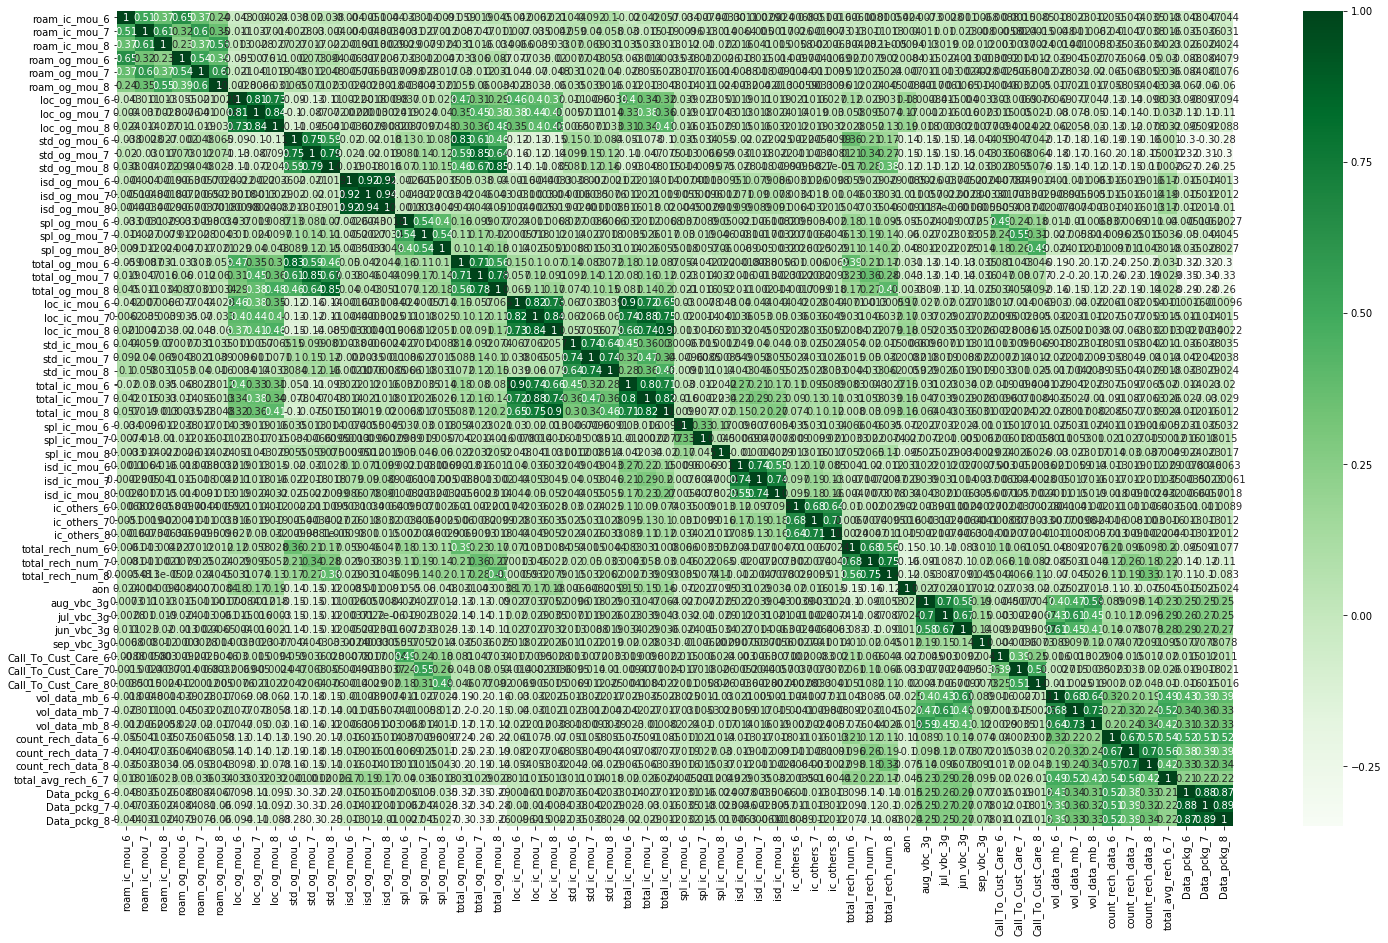

In [34]:
#Creating HEat Map of numeric variables

f = plt.figure(figsize=(25, 15))
sns.heatmap(Telecom_churn_Priority_df[final_columns].corr(), annot=True, cmap=plt.cm.Greens)
plt.show()


In [35]:
corr_list =['Data_pckg_7']

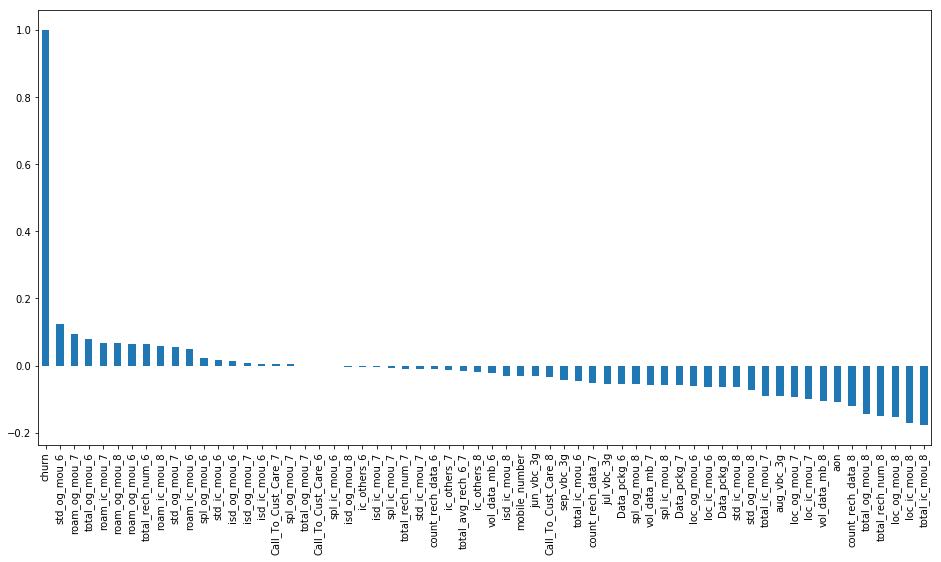

In [36]:
plt.figure(figsize=(16, 8))

Telecom_churn_Priority_df.corr()['churn'].sort_values(ascending = False).plot(kind='bar')


#### The above chart shows a correlation of the variables with the churn variable. It shows both +ve and -ve correlation between the variables.

#### From the Graph we observe a huge correlation with total_ic_mou_8. The correlation is a -ve correlation though but a huge one. From the chart, we get the below variables as having an impact on the churn:
1. total_ic_mou_8
2. loc_ic_mou_8
3. total_rech_num_8

From above we observe that the total fields are impacting the actual analysis. So, we will remove the total fields so as to be able to identify the actual variables which would be having the impact.


In [37]:
#Removing the total variables 
final_columns.remove('total_ic_mou_8')
final_columns.remove('total_rech_num_8')
final_columns.remove('total_rech_num_7')
final_columns.remove('total_rech_num_6')
final_columns.remove('total_og_mou_6')
final_columns.remove('total_ic_mou_7')
final_columns.remove('total_og_mou_7')
final_columns.remove('total_og_mou_8')
final_columns.remove('total_ic_mou_6')



In [38]:

#Dropping columns from the Dataframe
Telecom_churn_Priority_df.drop(columns=['total_ic_mou_8','total_rech_num_8','total_og_mou_7','total_og_mou_8','total_ic_mou_6','total_ic_mou_7','total_rech_num_7','total_rech_num_6','total_og_mou_6'],inplace=True)


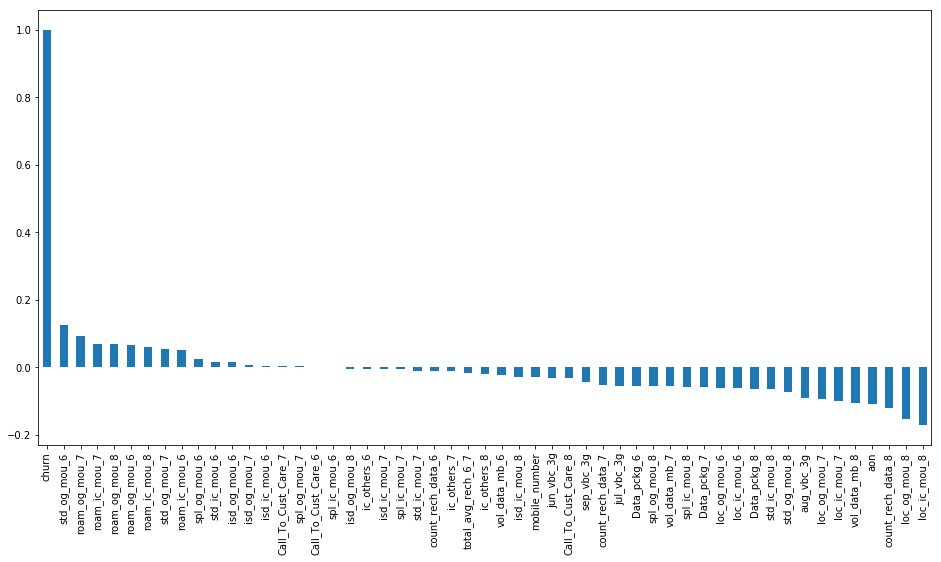

In [39]:
#Remake the model to see the highly correlated variables
plt.figure(figsize=(16, 8))

Telecom_churn_Priority_df.corr()['churn'].sort_values(ascending = False).plot(kind='bar')


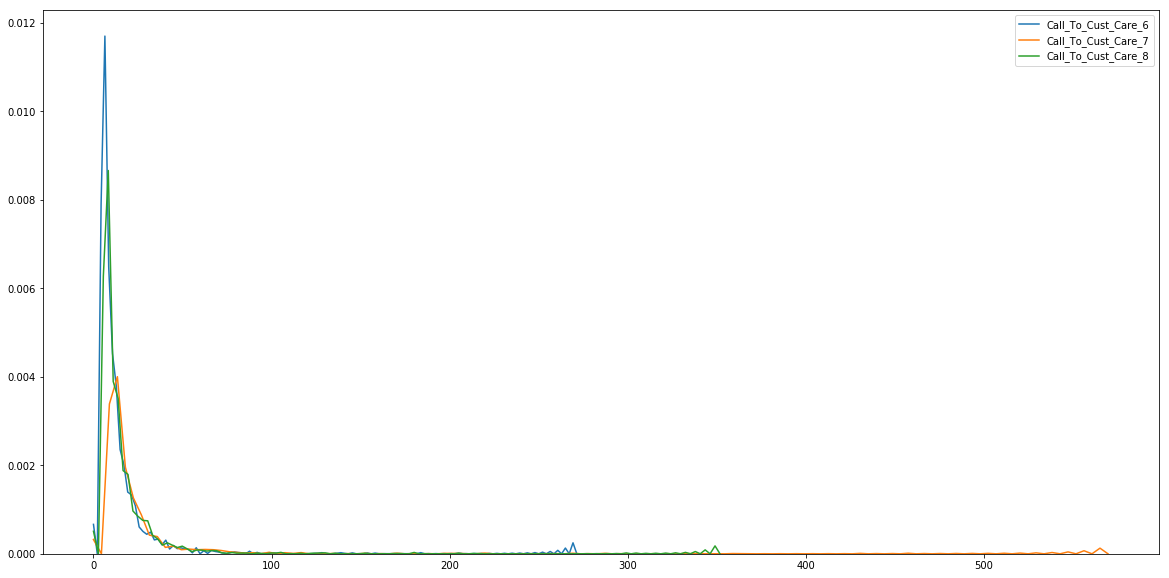

In [40]:
plt.figure(figsize=(20, 10))

sns.distplot(Telecom_churn_Priority_df[['Call_To_Cust_Care_6']], hist=False, label='Call_To_Cust_Care_6')
sns.distplot(Telecom_churn_Priority_df[['Call_To_Cust_Care_7']], hist=False, label='Call_To_Cust_Care_7')
sns.distplot(Telecom_churn_Priority_df[['Call_To_Cust_Care_8']], hist=False, label='Call_To_Cust_Care_8')
plt.show()

In [41]:
#Picking the churned data so as to evaluate the churned customers better

Churned_df = Telecom_churn_Priority_df.loc[Telecom_churn_Priority_df['churn'] == 1]
Churned_df.head()

mobile_number  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0       7000842753           0.00           0.00           0.00   
7       7000701601          16.23          33.49          31.64   
67      7000800341           0.00           0.00           0.00   
86      7000175867           0.00          14.56           0.00   
111     7001300706           0.00           0.00           0.00   

     roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_mou_6  loc_og_mou_7  \
0             0.00           0.00           0.00          0.00          0.00   
7            23.74          12.59          38.06        422.15        533.90   
67            0.00           0.00           0.00          0.00          0.00   
86            0.00           2.26           1.71         62.21         28.66   
111           0.00           0.00           0.00         99.02         15.60   

     loc_og_mou_8  ...  vol_data_mb_7  vol_data_mb_8  count_rech_data_6  \
0            0.00  ...         152.08         115.36                1.0   
7          255.79  ...           0.00           0.00                0.0   
67           0.00  ...        3208.92           0.00                1.0   
86           0.00  ...           0.00           0.00                2.0   
111          0.00  ...           0.00           0.00                2.0   

     count_rech_data_7  count_rech_data_8  total_avg_rech_6_7  Data_pckg_6  \
0                  1.0                1.0               559.0            1   
7                  0.0                0.0              1185.0            0   
67                 1.0                0.0               707.0            1   
86                 0.0                0.0               528.0            1   
111                0.0                0.0               644.0            1   

     Data_pckg_7  Data_pckg_8  churn  
0              1            1      1  
7              0            0      1  
67             1            1      1  
86             0            0      1  
111            1            1      1  

[5 rows x 53 columns]

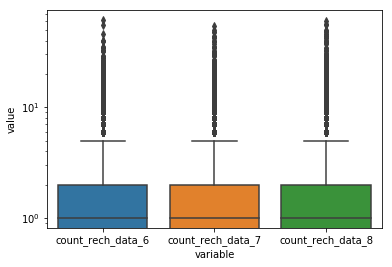

In [42]:
sns.boxplot(x="variable", y="value", data = pd.melt(Telecom_churn_Priority_df[['count_rech_data_6', 'count_rech_data_7', 'count_rech_data_8']]))
plt.yscale('log')
plt.show()


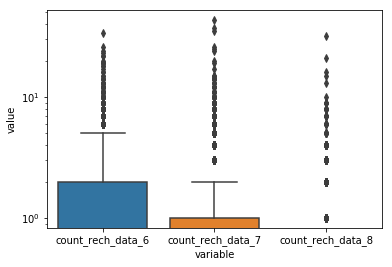

'\nWe observe a drop in the number of recharges done churning customers\n'

In [43]:
sns.boxplot(x="variable", y="value", data = pd.melt(Churned_df[['count_rech_data_6', 'count_rech_data_7', 'count_rech_data_8']]))
plt.yscale('log')
plt.show()


'''
We observe a drop in the number of recharges done churning customers
'''

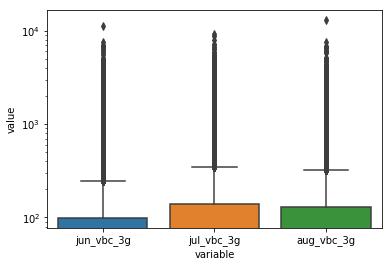

In [44]:
sns.boxplot(x="variable", y="value", data = pd.melt(Telecom_churn_Priority_df[['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g']]))
plt.yscale('log')
plt.show()


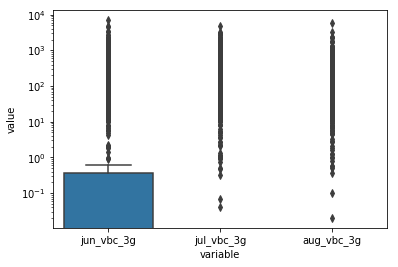

In [45]:
sns.boxplot(x="variable", y="value", data = pd.melt(Churned_df[['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g']]))
plt.yscale('log')
plt.show()


#### The above two charts are very interesting. From the charts it seems that payment based on usage is on the increase so everything should be good. But, when we isolate the data of the churned customers we observe that this is far from the truth and volume based usage is drastically on the decline by the churning users.

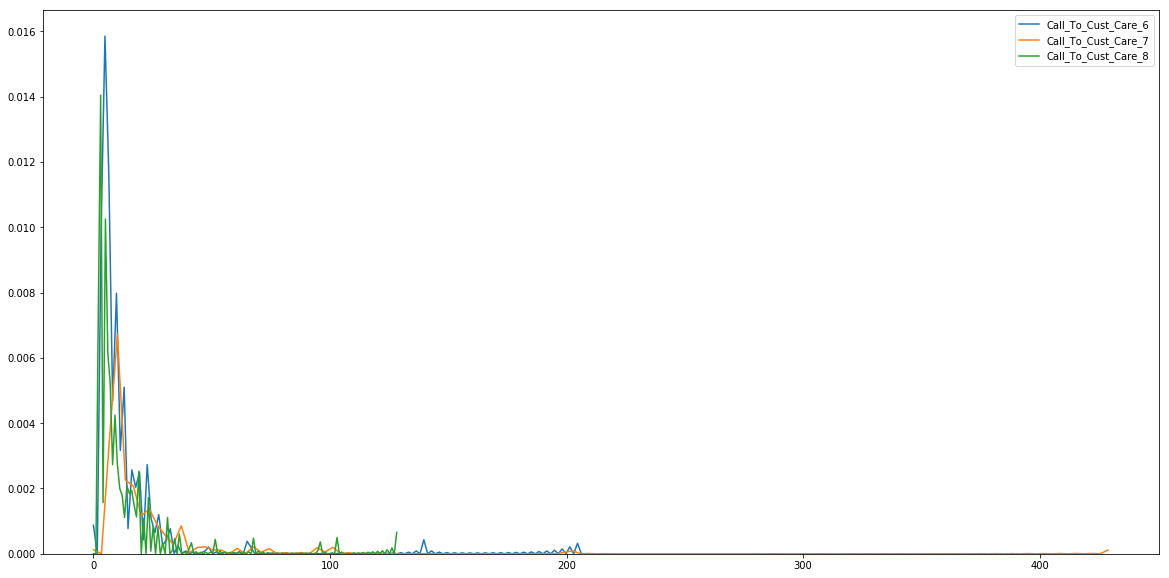

In [46]:
plt.figure(figsize=(20, 10))

sns.distplot(Churned_df[['Call_To_Cust_Care_6']], hist=False, label='Call_To_Cust_Care_6')
sns.distplot(Churned_df[['Call_To_Cust_Care_7']], hist=False, label='Call_To_Cust_Care_7')
sns.distplot(Churned_df[['Call_To_Cust_Care_8']], hist=False, label='Call_To_Cust_Care_8')
plt.show()

#### The above is the call to Customer Care during June,July and August. We see many calls in the month of June with July and close by and an again increase in the month of August. This could be some users/customers calling customer care to get a resolution to their problem or looking for new schemes. 

In [47]:
Telecom_churn_Priority_df

mobile_number  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         7000842753           0.00           0.00           0.00   
7         7000701601          16.23          33.49          31.64   
8         7001524846           0.00           0.00           0.00   
21        7002124215           0.00           0.00           0.00   
23        7000887461           0.00           0.00           0.00   
33        7000149764           0.00           0.00           0.00   
38        7000815202           0.00           0.00           0.00   
41        7000721289           0.00           0.00           0.00   
48        7000294396           0.00           0.00           0.00   
53        7002188521           0.00           0.00           0.00   
56        7002180748           0.00           0.00           0.00   
57        7001682585           0.00           0.00           0.00   
61        7000152517           0.00           0.00           0.00   
67        7000800341           0.00           0.00           0.00   
69        7002393996           0.00           1.31           0.00   
73        7002402996           0.00           0.00           0.00   
77        7001328263           0.00           0.00           0.00   
86        7000175867           0.00          14.56           0.00   
87        7001728145           3.06           0.00           0.00   
91        7000160837           0.00           0.00           0.00   
92        7001606600           0.00           0.00           0.00   
96        7001480390           0.00           0.00           0.00   
101       7001746121          91.03         188.34          73.19   
102       7001631060           0.00           6.43           0.00   
103       7002236431           0.00           0.00           0.00   
104       7002144559           0.00           0.00           0.00   
105       7000208415           0.00           0.00           0.00   
111       7001300706           0.00           0.00           0.00   
115       7001453769           0.00           0.00           0.00   
124       7000302971           0.00           0.00           0.00   
...              ...            ...            ...            ...   
99896     7002362186           0.00           0.00           0.00   
99899     7001632563           0.00           0.00           0.00   
99902     7002142544           0.00           0.00           0.00   
99903     7000802548           1.00           0.00           0.00   
99904     7000649339           0.00           0.00           0.00   
99921     7000157295           0.00           0.00           0.00   
99922     7001602180           0.00           0.00           0.00   
99923     7000571771           0.00           0.00           0.00   
99924     7001581208           0.00           0.00           0.00   
99925     7000877443           1.00           0.00           0.00   
99927     7001570091           0.00           0.00           0.00   
99929     7002128793           0.00           0.00           0.00   
99931     7001904289          45.19           0.00           0.00   
99935     7002109027           0.00           1.63           0.00   
99937     7000534033           0.00           0.00           0.00   
99939     7001631916           0.00           0.00           5.56   
99941     7002281862           0.00           0.00           0.00   
99942     7002067257           0.00           0.00           0.00   
99947     7001176686           0.00           0.00           0.00   
99955     7000258042           0.00           0.00           0.00   
99957     7002108597           5.58           0.00           0.00   
99959     7001792051           1.01          12.09          14.13   
99963     7000484880           0.00           0.00           0.00   
99965     7000519799           0.00           0.00           0.00   
99970     7001386760           5.06           0.00           0.00   
99981     7000630859           0.00           0.00           0.00   
99984

### DATA PREPARATION

In [48]:
#Checking shape of the Dataframe
Telecom_churn_Priority_df.shape

(29953, 53)

In [49]:
# Outlier treatment for the Data so as to be able to proceed further

Q1 = Telecom_churn_Priority_df['total_avg_rech_6_7'].quantile(0.05)
Q3 = Telecom_churn_Priority_df['total_avg_rech_6_7'].quantile(0.95)
IQR = Q3 - Q1
Telecom_churn_Priority_df = Telecom_churn_Priority_df[(Telecom_churn_Priority_df['total_avg_rech_6_7'] >= Q1 - 1.5*IQR) & (Telecom_churn_Priority_df['total_avg_rech_6_7'] <= Q3 + 1.5*IQR)]


In [50]:
Telecom_churn_Priority_df.describe(percentiles=[.25,.5,.75,.90,.95,.99])

mobile_number  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count   2.966900e+04   29669.000000   29669.000000   29669.000000   
mean    7.001206e+09      16.142450      12.636395      12.437162   
std     6.905363e+05      76.375591      75.924218      73.917800   
min     7.000000e+09       0.000000       0.000000       0.000000   
25%     7.000610e+09       0.000000       0.000000       0.000000   
50%     7.001203e+09       0.000000       0.000000       0.000000   
75%     7.001803e+09       0.000000       0.000000       0.000000   
90%     7.002165e+09      27.520000      14.314000      14.992000   
95%     7.002285e+09      85.028000      55.488000      56.078000   
99%     7.002385e+09     341.923200     280.949600     281.150800   
max     7.002411e+09    2613.310000    3813.290000    4169.810000   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_mou_6  \
count   29669.000000   29669.000000   29669.000000  29669.000000   
mean       26.626865      20.090306      19.809884    254.610299   
std       116.291319      95.433889     104.470505    378.523853   
min         0.000000       0.000000       0.000000      0.000000   
25%         0.000000       0.000000       0.000000     32.540000   
50%         0.000000       0.000000       0.000000    125.140000   
75%         0.000000       0.000000       0.000000    333.100000   
90%        50.682000      31.184000      28.656000    639.456000   
95%       145.670000     104.354000     100.344000    913.412000   
99%       531.135600     435.748000     426.914400   1789.594400   
max      3775.110000    2812.040000    5337.040000  10643.370000   

       loc_og_mou_7  loc_og_mou_8  ...  vol_data_mb_7  vol_data_mb_8  \
count  29669.000000  29669.000000  ...   29669.000000   29669.000000   
mean     255.677959    236.043699  ...     459.471186     428.849723   
std      375.205349    362.815123  ...     800.951004     816.960896   
min        0.000000      0.000000  ...       0.000000       0.000000   
25%       35.020000     22.800000  ...       0.000000       0.000000   
50%      128.840000    111.580000  ...      47.130000       0.000000   
75%      334.560000    311.200000  ...     656.270000     599.670000   
90%      637.268000    607.544000  ...    1340.668000    1272.662000   
95%      905.126000    860.108000  ...    1901.264000    1878.818000   
99%     1745.232400   1661.691600  ...    3594.688000    3733.218400   
max     7674.760000  11039.900000  ...   16652.210000   16020.110000   

       count_rech_data_6  count_rech_data_7  count_rech_data_8  \
count       29669.000000       29669.000000       29669.000000   
mean            1.579325           1.750244           1.548721   
std             2.526298           2.728584           2.735958   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             1.000000           1.000000           1.000000   
75%             2.000000           2.000000           2.000000   
90%             4.000000           5.000000           5.000000   
95%             7.000000           8.000000           7.000000   
99%            12.000000          12.000000          12.000000   
max            46.000000          34.000000          57.000000   

       total_avg_rech_6_7   Data_pckg_6   Data_pckg_7   Data_pckg_8  \
count        29669.000000  29669.000000  29669.000000  29669.000000   
mean          1060.219787      0.555260      0.545586      0.529509   
std            762.738468      0.496945      0.497926      0.499137   
min            478.500000      0.000000      0.000000      0.000000   
25%            602.000000      0.000000      0.000000      0.000000   
50%            796.000000      1.000000      1.000000      1.000000   
75%           1189.000000      1.000000      1.000000      1.000000   
90%           1910.000000      1.000000      1.000000      1.000000   
95%           2574.600000      1.000000      1.000000      1.000

In [51]:
Telecom_churn_Priority_df.shape

(29669, 53)

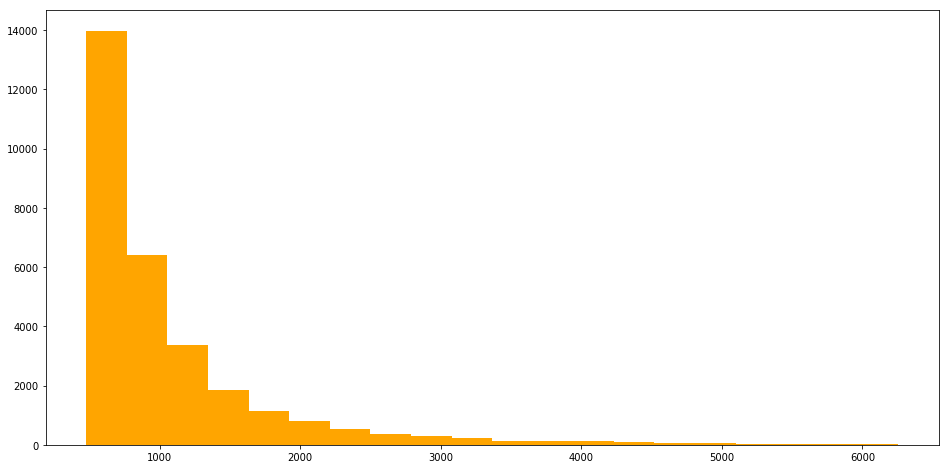

In [52]:
# Plotting Histogram for SalePrice - to check if it is Normalized or not. it is one of the basic necessaities 
# of Linear regression
plt.figure(figsize=(16, 8))

plt.hist(Telecom_churn_Priority_df['total_avg_rech_6_7'],bins=20, color='orange')

plt.show()


#### There are no binary variables nor categorical variables. hence we will move straight to the step of standarsizing the data as all the columns are of numeric type

In [53]:
churn = (sum(Telecom_churn_Priority_df['churn'])/len(Telecom_churn_Priority_df['churn'].index))*100
churn

#We notice that there is a huge Data imbalance. Before creating the model, we will take care of the imbalace

8.14317974990731

### Creating Models now

In [54]:
#Standardizing the columns - since all columns are numeric, all except mobile number and churn need to be scaled
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Telecom_churn_Priority_df[final_columns] = scaler.fit_transform(Telecom_churn_Priority_df[final_columns])
final_columns.remove('total_avg_rech_6_7')


In [55]:
from sklearn.model_selection import train_test_split
X = Telecom_churn_Priority_df[final_columns]
y = Telecom_churn_Priority_df['churn']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.2,random_state=100)


#### Creating the first Model - Creating Logistic Regression Model - we will be using PCA along with the Logisitc Regression Model

In [56]:
import statsmodels.api as sm

In [57]:
# Model with imbalances
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20768
Model:                            GLM   Df Residuals:                    20717
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3942.4
Date:                Mon, 27 Jan 2020   Deviance:                       7884.9
Time:                        22:27:44   Pearson chi2:                 3.95e+11
No. Iterations:                    11   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.5562      0.118    -38.728      0.000      -4.787      -4.326
roam_ic_mou_6           0.1076      0.042      2.574      0.010       0.026       0.189
roam_ic_mou_7           0.0467      0.038      1.239      0.215      -0.027       0.121
roam_ic_mou_8          -0.0806      0.036     -2.228      0.026      -0.152      -0.010
roam_og_mou_6           0.0555      0.037      1.497      0.134      -0.017       0.128
roam_og_mou_7           0.1420      0.038      3.733      0.000       0.067       0.217
roam_og_mou_8          -0.0985      0.039     -2.507      0.012      -0.176      -0.021
loc_og_mou_6            0.0541      0.057      0.946      0.344      -0.058       0.166
loc_og_mou_7            0.3698      0.085      4.346      0.000       0.203       0.537
loc_og_mou_8           -0.9779      0.135     -7.251      0.000      -1.242      -0.714
std_og_mou_6            0.1535      0.038      4.071      0.000       0.080       0.227
std_og_mou_7            0.2496      0.050      5.027      0.000       0.152       0.347
std_og_mou_8           -0.8250      0.064    -12.799      0.000      -0.951      -0.699
isd_og_mou_6            0.0723      0.034      2.134      0.033       0.006       0.139
isd_og_mou_7            0.1185      0.057      2.076      0.038       0.007       0.230
isd_og_mou_8           -0.1912      0.068     -2.826      0.005      -0.324      -0.059
spl_og_mou_6            0.0798      0.041      1.970      0.049       0.000       0.159
spl_og_mou_7           -0.0205      0.060     -0.344      0.731      -0.137       0.096
spl_og_mou_8           -0.1340      0.081     -1.662      0.096      -0.292       0.024
loc_ic_mou_6            0.2029      0.063      3.231      0.001       0.080       0.326
loc_ic_mou_7            0.4231      0.089      4.767      0.000       0.249       0.597
loc_ic_mou_8           -2.5720      0.172    -14.943      0.000      -2.909      -2.235
std_ic_mou_6            0.1178      0.052      2.258      0.024       0.016       0.220
std_ic_mou_7            0.0521      0.059      0.878      0.380      -0.064       0.168
std_ic_mou_8           -0.5347      0.112     -4.760      0.000      -0.755      -0.315
spl_ic_mou_6            0.0419      0.039      1.070      0.285      -0.035       0.119
spl_ic_mou_7           -0.0936      0.068     -1.379      0.168      -0.227       0.039
spl_ic_mou_8           -0.4055      0.066     -6.178      0.000      -0.534      -0.277
isd_ic_mou_6            0.0306      0.047      0.648      0.517      -0.062       0.123
isd_ic_mou_7            0.1058      0.066      1.597      0.110      -0.024       0.236
isd_ic_mou_8           -0.1562      0.072     -2.165      0.030      -0.298      -0.015
ic_others_6            -0.0133      0.070     -0.191      0.849      -0.151       0.124
ic_others_7            -0.0973      0.080     -1.223      0.221      -0.253       

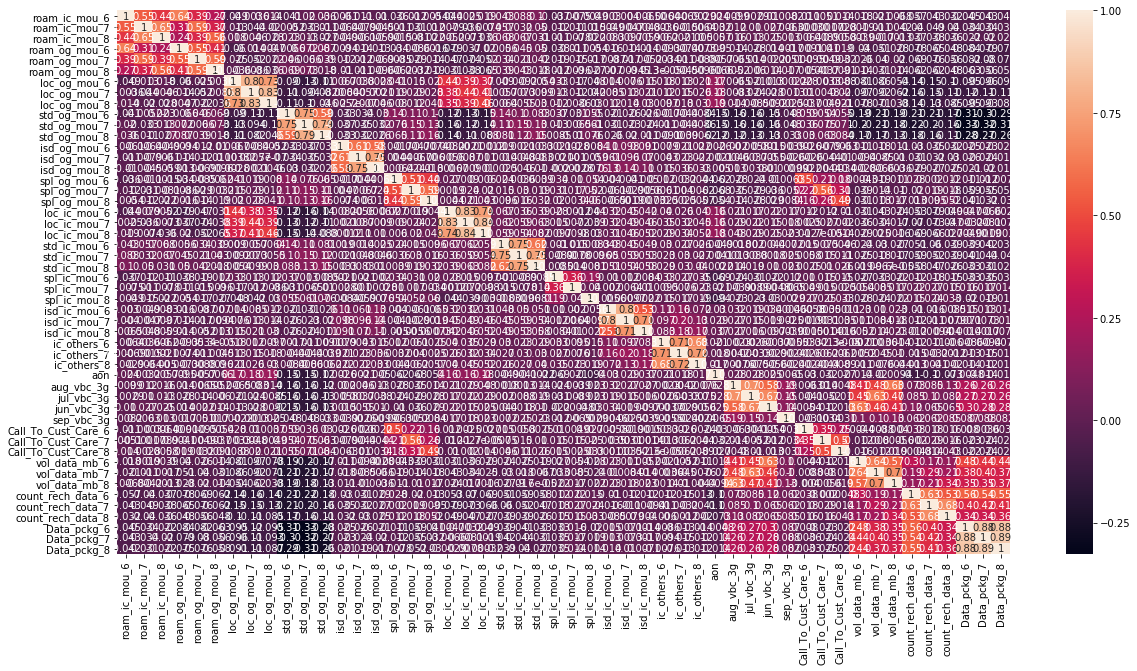

In [58]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X_train.corr(),annot = True)

#### Looking at the Correlation Matrix, we see that some of the variables are highly correlated. we drop some of the highly correlated variables and will create a heatmap again after that.


In [59]:
#Dropping columns
#X_train.drop(columns=['Data_pckg_8','Data_pckg_7','Data_pckg_6','isd_og_mou_7','std_og_mou_7','std_og_mou_6','loc_ic_mou_6','loc_ic_mou_7','jul_vbc_3g','ic_others_7','ic_others_6','vol_data_mb_7','isd_ic_mou_6','std_ic_mou_7','isd_ic_mou_6','isd_ic_mou_7','roam_og_mou_6','roam_og_mou_7','count_rech_data_7','loc_og_mou_6','loc_og_mou_7'],inplace=True)
#X_test.drop(columns=['Data_pckg_8','Data_pckg_7','Data_pckg_6','isd_og_mou_7','std_og_mou_7','std_og_mou_6','loc_ic_mou_6','loc_ic_mou_7','jul_vbc_3g','ic_others_7','ic_others_6','vol_data_mb_7','isd_ic_mou_6','std_ic_mou_7','isd_ic_mou_6','isd_ic_mou_7','roam_og_mou_6','roam_og_mou_7','count_rech_data_7','loc_og_mou_6','loc_og_mou_7'],inplace=True)

X_train.drop(columns=['Data_pckg_8','Data_pckg_7','Data_pckg_6','std_og_mou_7','isd_og_mou_6','isd_og_mou_7','std_ic_mou_7','std_ic_mou_6','ic_others_8','jul_vbc_3g','vol_data_mb_6','vol_data_mb_7','count_rech_data_8','ic_others_6','ic_others_7','isd_ic_mou_7','loc_ic_mou_7','loc_ic_mou_6','loc_ic_mou_8','loc_og_mou_7','loc_og_mou_6','roam_ic_mou_7','count_rech_data_6','aug_vbc_3g','spl_og_mou_7','spl_og_mou_6','std_og_mou_6','roam_og_mou_6','roam_og_mou_7','roam_ic_mou_6'],inplace=True)
X_test.drop(columns=['Data_pckg_8','Data_pckg_7','Data_pckg_6','std_og_mou_7','isd_og_mou_6','isd_og_mou_7','std_ic_mou_7','std_ic_mou_6','ic_others_8','jul_vbc_3g','vol_data_mb_6','vol_data_mb_7','count_rech_data_8','ic_others_6','ic_others_7','isd_ic_mou_7','loc_ic_mou_7','loc_ic_mou_6','loc_ic_mou_8','loc_og_mou_7','loc_og_mou_6','roam_ic_mou_7','count_rech_data_6','aug_vbc_3g','spl_og_mou_7','spl_og_mou_6','std_og_mou_6','roam_og_mou_6','roam_og_mou_7','roam_ic_mou_6'],inplace=True)

#X_test.drop(columns=['Data_pckg_8','Data_pckg_7','Data_pckg_6','ic_others_8','aug_vbc_3g','std_ic_mou_8','std_og_mou_8','loc_og_mou_8'],inplace=True)



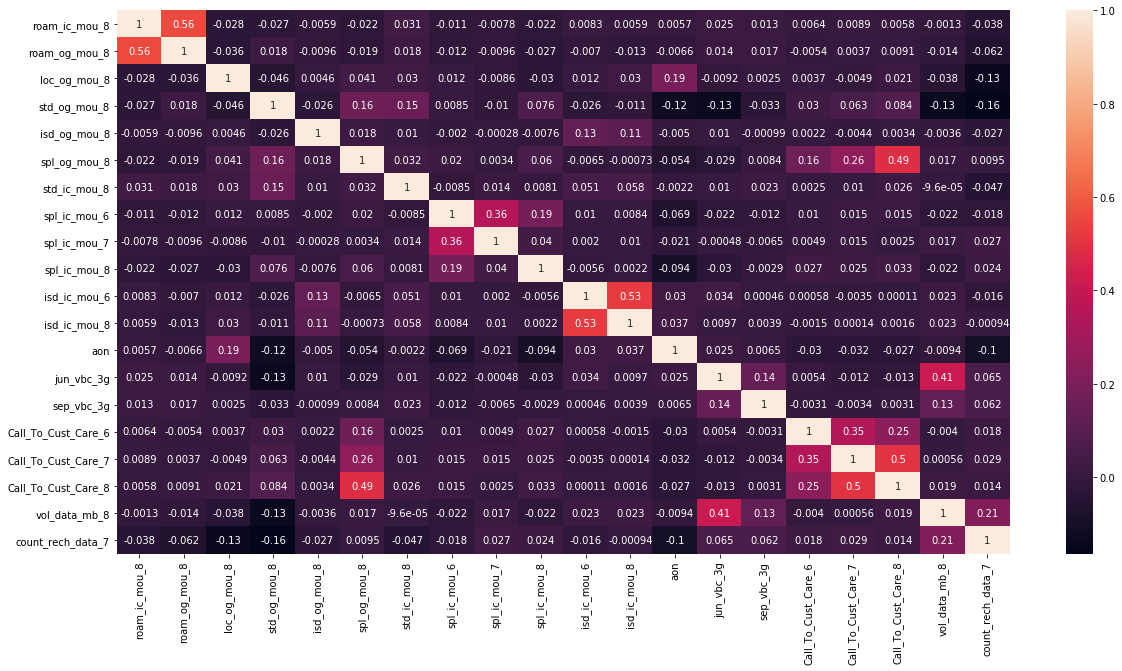

In [60]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X_train.corr(),annot = True)

In [61]:
X_train.shape

(20768, 20)

In [62]:
#Checking imbalance before applying SMOTE
print(sum(y_train == 1))
print(sum(y_train == 0))

1669
19099


In [63]:
#Applying SMOTE for removing imbalances - for further modelling we will 
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state = 2) 


In [64]:
X_train_SMT, y_train_SMT = smt.fit_sample(X_train, y_train.ravel())

In [65]:
print(sum(y_train_SMT == 1))
print(sum(y_train_SMT == 0))

19099
19099


In [66]:
y_train_SMT = y_train_SMT.reshape(-1)

In [67]:
y_train_SMT

array([1, 0, 0, ..., 1, 1, 1])

In [68]:
X_train_SMT.head()

roam_ic_mou_8  roam_og_mou_8  loc_og_mou_8  std_og_mou_8  isd_og_mou_8  \
0       0.218393       1.317429     -0.650600     -0.500596     -0.079761   
1      -0.168259      -0.189625      0.525032     -0.320618     -0.079761   
2      -0.002126      -0.189625      0.302435     -0.361210     -0.079761   
3      -0.168259      -0.189625     -0.360255      2.026475     -0.079761   
4      -0.168259      -0.189625      2.648491     -0.500316     -0.079761   

   spl_og_mou_8  std_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  \
0     -0.321658     -0.316897     -0.324044     -0.108411     -0.239699   
1     -0.321658      0.849196     -0.324044     -0.108411     -0.239699   
2     -0.274459      0.151041     -0.324044     -0.108411     -0.239699   
3      0.077075     -0.258820     -0.324044      3.175850     -0.239699   
4      0.223096     -0.229457     -0.324044     -0.108411     -0.239699   

   isd_ic_mou_6  isd_ic_mou_8       aon  jun_vbc_3g  sep_vbc_3g  \
0     -0.140493     -0.156414 -0.651255   -0.391656   -0.151485   
1     -0.140493     -0.156414  2.545219   -0.391656   -0.151485   
2     -0.140493     -0.156414  1.961007    0.341558    0.041845   
3     -0.140493     -0.156414 -0.038876   -0.391656   -0.151485   
4     -0.140493     -0.156414  1.193185   -0.391656   -0.151485   

   Call_To_Cust_Care_6  Call_To_Cust_Care_7  Call_To_Cust_Care_8  \
0            10.067850             0.561689            -0.237497   
1            -0.249356            -0.205753            -0.237497   
2            -0.249356            -0.205753            -0.237497   
3            -0.249356            -0.029994            -0.237497   
4            -0.249356            -0.205753            -0.237497   

   vol_data_mb_8  count_rech_data_7  
0      -0.524942          -0.641459  
1       0.077508           0.091535  
2      -0.336068           0.091535  
3      -0.524942          -0.641459  
4      -0.524942          -0.641459

### Using PCA on the Data

In [69]:
from sklearn.decomposition import PCA

In [70]:
pca = PCA(random_state=42)
pca.fit(X_train_SMT)
pca.components_

array([[ 0.80691315,  0.58080359, -0.03655636, -0.01155403, -0.00726011,
        -0.01649806,  0.00639894, -0.03420882, -0.01864624, -0.02954261,
        -0.01198864, -0.01036691,  0.01068008, -0.01129888, -0.00194033,
        -0.00216489,  0.01294648,  0.00589612, -0.03341455, -0.07424068],
       [ 0.00855218, -0.00432327,  0.03596121,  0.14195437,  0.00547451,
         0.30541534,  0.05508086,  0.06491841,  0.04986918,  0.06798805,
         0.00405045,  0.01262693, -0.03924504, -0.03547632,  0.00253621,
         0.52679746,  0.6433722 ,  0.41978242,  0.00384918,  0.01188878],
       [ 0.06308572, -0.01729715,  0.06712995, -0.25725017,  0.10595167,
        -0.01125382,  0.02029964, -0.184673  , -0.06113007, -0.07576948,
         0.26032296,  0.21387943,  0.16913042,  0.58999662,  0.13257469,
         0.05227215,  0.0536057 ,  0.0263681 ,  0.49916666,  0.32623953],
       [ 0.05713871,  0.01531512,  0.05749294,  0.06899242,  0.10544131,
         0.03353114,  0.08836268,  0.65021459,  

In [71]:
pca.explained_variance_ratio_

array([0.13989858, 0.10781572, 0.07604099, 0.07075168, 0.06879872,
       0.05844275, 0.05401737, 0.04771591, 0.04431826, 0.0405357 ,
       0.03910561, 0.03438579, 0.03284626, 0.03163004, 0.03118225,
       0.0292363 , 0.02807483, 0.02654063, 0.0223163 , 0.01634632])

<BarContainer object of 20 artists>

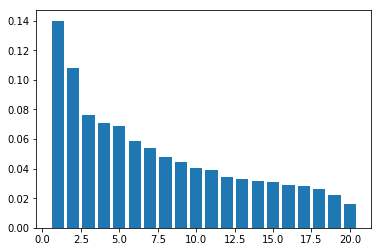

In [72]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

In [73]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

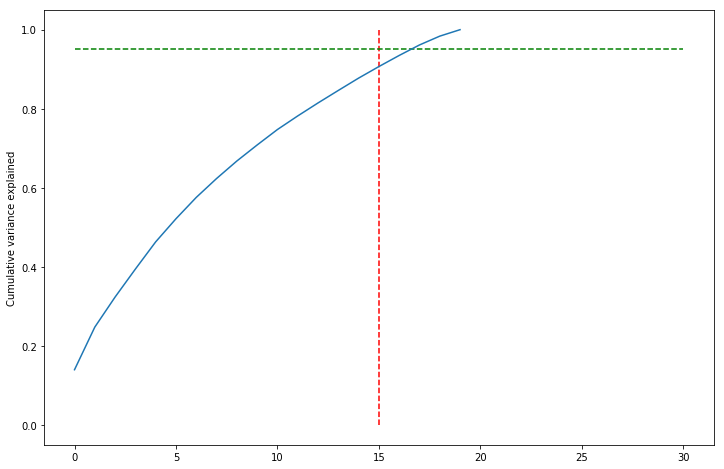

In [74]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [75]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=16)
df_train_pca = pca_final.fit_transform(X_train_SMT)
df_train_pca.shape

(38198, 16)

In [76]:

corrmat = np.corrcoef(df_train_pca.transpose())
corrmat.shape
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(5934, 16)

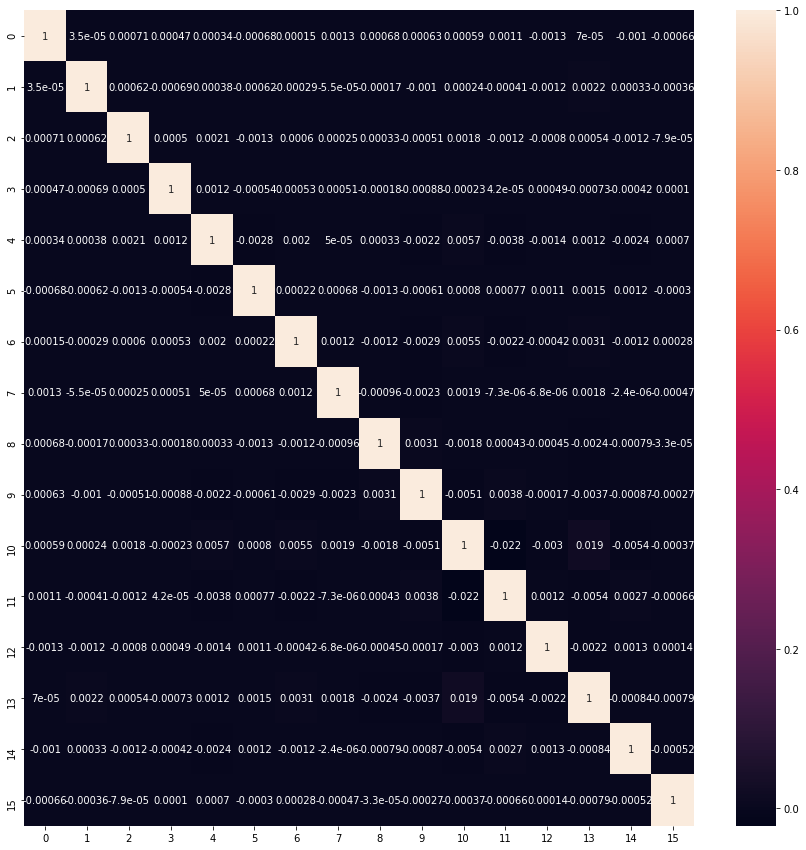

In [77]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

### Applying Logisitic Regression

In [78]:
from sklearn.linear_model import LogisticRegression
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca, y_train_SMT)

y_train_pred = model_pca.predict_proba(df_train_pca)[:,1]


In [79]:
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]


In [80]:
import pandas as pd
y_train_pred_final = pd.DataFrame()
#y_train_pred_final = pd.DataFrame({'Churn':y_train_SMT.values, 'Churn_Prob':pred_probs_test})
y_train_pred_final['Churn'] = pd.Series(y_train_SMT)
y_train_pred_final['Churn_Prob'] = y_train_pred

y_train_pred_final.head()

Churn  Churn_Prob
0      1    0.743490
1      0    0.030789
2      0    0.070508
3      0    0.234192
4      0    0.004095

In [81]:
from sklearn.linear_model import LogisticRegression
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_test_pca, y_test)

y_test_pred = model_pca.predict_proba(df_test_pca)[:,1]


In [82]:
#Test Data predictions
import pandas as pd
y_test_pred_final = pd.DataFrame()

y_test_pred_final['Churn'] = pd.Series(y_test)
y_test_pred_final['Churn_Prob'] = y_test_pred

y_test_pred_final.head()

Churn  Churn_Prob
12242      0    0.093416
65406      1    0.000060
4558       0    0.006734
30497      0    0.027683
43559      0    0.243373

In [83]:
#TRAIN 
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Churn  Churn_Prob  predicted
0      1    0.743490          1
1      0    0.030789          0
2      0    0.070508          0
3      0    0.234192          0
4      0    0.004095          0

In [84]:
#TEST
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head()

Churn  Churn_Prob  predicted
12242      0    0.093416          0
65406      1    0.000060          0
4558       0    0.006734          0
30497      0    0.027683          0
43559      0    0.243373          0

In [85]:

print("TRAIN ROC -  ",metrics.roc_auc_score(y_train_SMT, y_train_pred))
print("TEST ROC -  ",metrics.roc_auc_score(y_test, y_test_pred))


TRAIN ROC -   0.8722399144554489
TEST ROC -   0.8867101267853092


In [86]:
#----TRAIN CONFUSION METRICS
# Let's take a look at the confusion matrix again 
confusion_Train = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion_Train

array([[13961,  5138],
       [ 2886, 16213]], dtype=int64)

In [87]:
#----TEST CONFUSION METRICS
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.predicted )
confusion

array([[5413,   22],
       [ 464,   35]], dtype=int64)

In [88]:
#Checking Accuracy 
# Let's check the overall accuracy.
print("TRAIN Accuracy - ",metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print("TEST Accuracy - ",metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.predicted))

TRAIN Accuracy -  0.789936645897691
TEST Accuracy -  0.9180990899898888


#### Metrics of Predicted Test Data 

In [89]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [90]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.07014028056112225

In [91]:
# Let us calculate specificity
TN / float(TN+FP)

0.9959521619135234

In [92]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.004047838086476541


In [93]:
# positive predictive value 
print (TP / float(TP+FP))

0.6140350877192983


In [94]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9210481538199762


An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [95]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [96]:
#fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
fpr, tpr, thresholds = metrics.roc_curve( y_test_pred_final.Churn, y_test_pred_final.Churn_Prob, drop_intermediate = False )

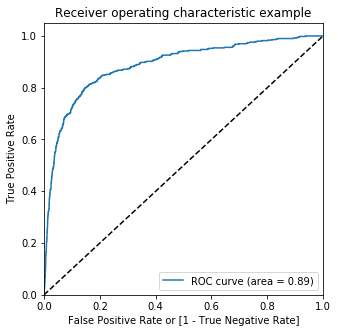

In [97]:
draw_roc(y_test_pred_final.Churn, y_test_pred_final.Churn_Prob)

Finding the Optimal Cutoff point

In [98]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_test_pred_final[i]= y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_test_pred_final.head()

Churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  \
12242      0    0.093416          0    1    0    0    0    0    0    0    0   
65406      1    0.000060          0    1    0    0    0    0    0    0    0   
4558       0    0.006734          0    1    0    0    0    0    0    0    0   
30497      0    0.027683          0    1    0    0    0    0    0    0    0   
43559      0    0.243373          0    1    1    1    0    0    0    0    0   

       0.8  0.9  
12242    0    0  
65406    0    0  
4558     0    0  
30497    0    0  
43559    0    0

In [99]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.084092  1.000000  0.000000
0.1   0.1  0.796596  0.847695  0.791904
0.2   0.2  0.887934  0.707415  0.904508
0.3   0.3  0.921301  0.595190  0.951242
0.4   0.4  0.929558  0.372745  0.980681
0.5   0.5  0.918099  0.070140  0.995952
0.6   0.6  0.916582  0.024048  0.998528
0.7   0.7  0.915908  0.010020  0.999080
0.8   0.8  0.915908  0.006012  0.999448
0.9   0.9  0.916077  0.002004  1.000000


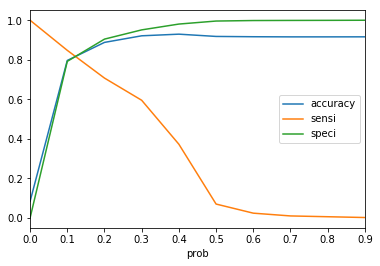

In [100]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [101]:
y_test_pred_final['final_predicted'] = y_test_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.1 else 0)

y_test_pred_final.head()

Churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  \
12242      0    0.093416          0    1    0    0    0    0    0    0    0   
65406      1    0.000060          0    1    0    0    0    0    0    0    0   
4558       0    0.006734          0    1    0    0    0    0    0    0    0   
30497      0    0.027683          0    1    0    0    0    0    0    0    0   
43559      0    0.243373          0    1    1    1    0    0    0    0    0   

       0.8  0.9  final_predicted  
12242    0    0                0  
65406    0    0                0  
4558     0    0                0  
30497    0    0                0  
43559    0    0                1

In [102]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.final_predicted)

0.7965958881024604

In [103]:
confusion2 = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.final_predicted )
confusion2

array([[4304, 1131],
       [  76,  423]], dtype=int64)

In [104]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [105]:
print("TP = ",TP)
print("TN = ",TN)
print("FP = ",FP)
print("FN = ",FN)

TP =  423
TN =  4304
FP =  1131
FN =  76


In [106]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8476953907815631

In [107]:
# Let us calculate specificity
TN / float(TN+FP)

0.7919043238270469

In [108]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.20809567617295308


In [109]:
# Positive predictive value 
print (TP / float(TP+FP))

0.2722007722007722


In [110]:
# Negative predictive value
print (TN / float(TN+ FN))

0.982648401826484


#### Simple Logistic Regression method

In [111]:
'''from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Second_model = LogisticRegression()

#Using the Train Data which has already gone through SMOTE 
Logi_result = Second_model.fit(X_train_SMT, y_train_SMT)

prediction_test = Second_model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))
'''

'from sklearn.linear_model import LogisticRegression\nfrom sklearn import metrics\n\nSecond_model = LogisticRegression()\n\n#Using the Train Data which has already gone through SMOTE \nLogi_result = Second_model.fit(X_train_SMT, y_train_SMT)\n\nprediction_test = Second_model.predict(X_test)\n# Print the prediction accuracy\nprint (metrics.accuracy_score(y_test, prediction_test))\n'

Using AdaBoost on the PCA model created for Logisitic Regression

In [112]:
from sklearn.ensemble import AdaBoostClassifier
ABoost_Model = AdaBoostClassifier(base_estimator=model_pca)

ABoost_Model.fit(X_train_SMT,y_train_SMT)
preds = ABoost_Model.predict(X_test)
metrics.accuracy_score(y_test, preds)


0.7153690596562184

Adaboost based on DecisiontreeClassifier which is the default - we observe that this gives a better result. PCA might not be the best of the methods - so we will explore somewhat more to see create another model.

In [113]:
from sklearn.ensemble import AdaBoostClassifier
ABoost_Model = AdaBoostClassifier()

ABoost_Model.fit(X_train_SMT,y_train_SMT)
preds = ABoost_Model.predict(X_test)
metrics.accuracy_score(y_test, preds)


0.8742837883383889

## Second model Using Random Forest

In [114]:
#Creating Random Forest with Default Hyper Parameters
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()


In [115]:
# fitting the Trains which have gone through SMOTE
rfc.fit(X_train_SMT,y_train_SMT)
# Making predictions
predictions = rfc.predict(X_test)

In [116]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
# Let's check the report of our default model
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5435
           1       0.56      0.67      0.61       499

    accuracy                           0.93      5934
   macro avg       0.76      0.81      0.79      5934
weighted avg       0.93      0.93      0.93      5934



In [117]:
print(accuracy_score(y_test,predictions))

0.9278732726659926


### Going to now proceed with the Hyper Parameter Tuning. We are going to be tuning the below HyperParameters :
1. max_depth
2. max_features
3. n_estimator

#### These 3 HyperParameters ought to help us create an optimal model with the number of features we would need and needed depth as well. 


In [118]:
# Tuning the Maximum Depth 
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,return_train_score='warn',
                   scoring="r2")
rf.fit(X_train_SMT, y_train_SMT)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [119]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.797689      0.026371         0.036893        0.000893   
1       2.030964      0.025819         0.060835        0.002893   
2       3.108494      0.109369         0.083200        0.000797   
3       3.797467      0.210534         0.101127        0.002317   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               2   {'max_depth': 2}           0.270681           0.334031   
1               7   {'max_depth': 7}           0.432461           0.501571   
2              12  {'max_depth': 12}           0.606806           0.696335   
3              17  {'max_depth': 17}           0.712042           0.795812   

   split2_test_score  split3_test_score  ...  mean_test_score  std_test_score  \
0           0.345026           0.315617  ...         0.316509        0.025384   
1           0.550785           0.514596  ...         0.500707        0.038395   
2           0.715707           0.697866  ...         0.683335        0.038887   
3           0.808901           0.795785  ...         0.783026        0.035825   

   rank_test_score  split0_train_score  split1_train_score  \
0                4            0.332941            0.336606   
1                3            0.552850            0.532692   
2                2            0.804699            0.781268   
3                1            0.928922            0.921461   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.302572            0.325632            0.319349   
1            0.523005            0.529566            0.527995   
2            0.787682            0.784548            0.780228   
3            0.922770            0.923034            0.924474   

   mean_train_score  std_train_score  
0          0.323420         0.012005  
1          0.533222         0.010302  
2          0.787685         0.008901  
3          0.924132         0.002579  

[4 rows x 21 columns]

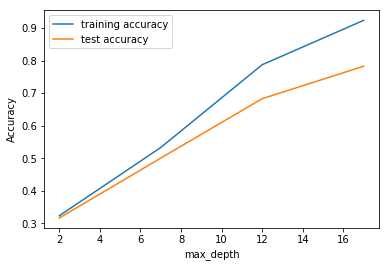

In [120]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#### From the chart we can see that there are two points where the test and train start drifting away. the first is at max_depth 7 and the drift gradual and the second is at 12, where the accuracy goes down much more. For this problem, we will go with max_depth 7

#### Tuning n_estimators - This is the number of Trees in the forest. 

In [121]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=8)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,return_train_score='warn',
                   scoring="r2")
rf.fit(X_train_SMT, y_train_SMT)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

In [122]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.380250      0.054646         0.068417        0.002410   
1      11.812223      0.120769         0.337490        0.006263   
2      25.185046      6.073209         1.197192        1.162185   
3      30.713461      1.589979         0.907380        0.082723   

  param_n_estimators                  params  split0_test_score  \
0                100   {'n_estimators': 100}           0.466492   
1                500   {'n_estimators': 500}           0.467539   
2                900   {'n_estimators': 900}           0.465969   
3               1300  {'n_estimators': 1300}           0.464398   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.540838           0.586387           0.548632  ...   
1           0.544503           0.585340           0.548108  ...   
2           0.542408           0.589005           0.547585  ...   
3           0.546073           0.590052           0.548108  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.541757        0.040777                1            0.591989   
1         0.541652        0.039742                2            0.594869   
2         0.540500        0.040624                4            0.598010   
3         0.541547        0.041657                3            0.595916   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.573532            0.570653            0.582578   
1            0.577197            0.575365            0.576557   
2            0.578768            0.573925            0.579306   
3            0.578768            0.574972            0.578258   

   split4_train_score  mean_train_score  std_train_score  
0            0.578651          0.579481         0.007484  
1            0.576688          0.580135         0.007391  
2            0.574724          0.580947         0.008794  
3            0.574463          0.580475         0.007908  

[4 rows x 21 columns]

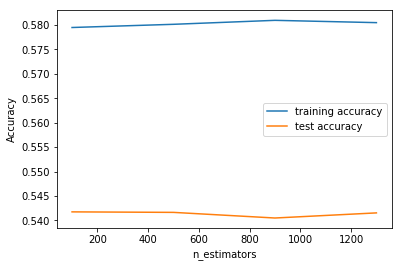

In [123]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [124]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20]}

# instantiate the model
rf = RandomForestClassifier(max_depth=8)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,error_score='raise',return_train_score='warn',
                   scoring="accuracy")
rf.fit(X_train_SMT, y_train_SMT)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [125]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.276923      0.081646         0.066429        0.006719   
1       3.985348      0.036874         0.063029        0.000765   
2       6.758337      0.091527         0.062435        0.001012   
3       9.478444      0.159973         0.062426        0.001007   

  param_max_features                params  split0_test_score  \
0                  4   {'max_features': 4}           0.867277   
1                  8   {'max_features': 8}           0.872644   
2                 14  {'max_features': 14}           0.874215   
3                 20  {'max_features': 20}           0.873691   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.886257           0.896728           0.887551  ...   
1           0.890707           0.902487           0.894620  ...   
2           0.893063           0.901571           0.901034  ...   
3           0.892408           0.899607           0.895405  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.885596        0.009845                4            0.898652   
1         0.891356        0.010097                3            0.907815   
2         0.894367        0.010599                1            0.913378   
3         0.892508        0.009924                2            0.912200   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.895543            0.894430            0.894401   
1            0.902742            0.903299            0.901535   
2            0.906342            0.908044            0.909159   
3            0.904346            0.905557            0.906672   

   split4_train_score  mean_train_score  std_train_score  
0            0.893648          0.895335         0.001765  
1            0.901927          0.903464         0.002261  
2            0.905822          0.908549         0.002693  
3            0.907425          0.907240         0.002689  

[4 rows x 21 columns]

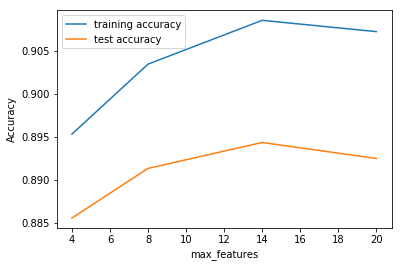

In [126]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [127]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [9,12],
   # 'min_samples_leaf': range(100, 400, 200),
   # 'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 8]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)
# Fit the grid search to the data
grid_search.fit(X_train_SMT, y_train_SMT)



Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

#### Getting the details of the Optimal Parameters for the Model

In [128]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.9247867791286329 using {'max_depth': 12, 'max_features': 8, 'n_estimators': 300}


In [129]:
#Creating the Final Model with teh recommended HyperPararmeters
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=12,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=8,
                             n_estimators=200)
# fit
rfc.fit(X_train_SMT,y_train_SMT)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
# predict
predictions = rfc.predict(X_test)
prediction_train = rfc.predict(X_train_SMT)

In [131]:
#GEtting the Probability calculated for making the prediction
prediction_prob = rfc.predict_proba(X_train_SMT)
prediction_prob

array([[0.12912897, 0.87087103],
       [0.98999537, 0.01000463],
       [0.79743899, 0.20256101],
       ...,
       [0.04595086, 0.95404914],
       [0.36140227, 0.63859773],
       [0.12816602, 0.87183398]])

In [132]:
#GEtting the Probability calculated for making the prediction
prediction_prob_test = rfc.predict_proba(X_test)
prediction_prob_test

array([[0.92786621, 0.07213379],
       [0.81228475, 0.18771525],
       [0.89306046, 0.10693954],
       ...,
       [0.64187174, 0.35812826],
       [0.94468963, 0.05531037],
       [0.46496719, 0.53503281]])

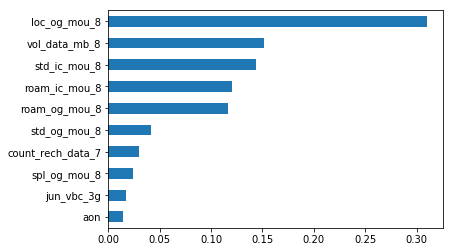

In [133]:
importances = rfc.feature_importances_
weights = pd.Series(importances,
                 index=X_train_SMT.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')


## From the above chart we can get the most important variables which seem to be impacting the model. They are as below:

1. loc_og_mou_8
2. vol_data_mb_8
3. roam_og_mou_8
4. std_ic_mou_8
5. roam_ic_mou_8

### However if we look at all incoming as a single variable and all outgoing as another single variable, then the important variables to look out for would be as follows (as per the model)
1. outgoing in August
2. volume of data used in Aug 
3. Roaming outgoing for Aug 
4. Std incoming for Aug
5. Recharge count in July



In [134]:
predictions

array([0, 0, 0, ..., 0, 0, 1])

In [135]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      5435
           1       0.43      0.80      0.56       499

    accuracy                           0.89      5934
   macro avg       0.70      0.85      0.75      5934
weighted avg       0.93      0.89      0.91      5934



In [136]:
print(confusion_matrix(y_test,predictions))

[[4901  534]
 [ 102  397]]


In [137]:
#Checking the churn actual and predicted to see accuracy
y_train_pred_Rforest = pd.DataFrame()
y_train_pred_Rforest['Churn'] = pd.Series(y_train_SMT)
y_train_pred_Rforest['Churn_Probability'] = pd.Series(prediction_prob[:,1])
y_train_pred_Rforest['Churn_Predicted'] = pd.Series(prediction_train)

#Creating table for test churn
y_test_pred_Rforest = pd.DataFrame({'Churn':y_test.values, 'Churn_Probability':pd.Series(prediction_prob_test[:,1]),'Churn_Predicted':pd.Series(predictions)  })


In [138]:
y_test_pred_Rforest.head()

Churn  Churn_Probability  Churn_Predicted
0      0           0.072134                0
1      1           0.187715                0
2      0           0.106940                0
3      0           0.288339                0
4      0           0.405936                0

In [139]:
y_train_pred_Rforest.head()

Churn  Churn_Probability  Churn_Predicted
0      1           0.870871                1
1      0           0.010005                0
2      0           0.202561                0
3      0           0.101234                0
4      0           0.014425                0

In [140]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_Rforest.Churn, y_train_pred_Rforest.Churn_Predicted)

0.8833446777318185

In [141]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [142]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.07014028056112225

In [143]:
# Let us calculate specificity
TN / float(TN+FP)

0.9959521619135234

In [144]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.004047838086476541


In [145]:
# positive predictive value 
print (TP / float(TP+FP))

0.6140350877192983


In [146]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9210481538199762


An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [147]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [148]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_Rforest.Churn, y_train_pred_Rforest.Churn_Probability, drop_intermediate = False )


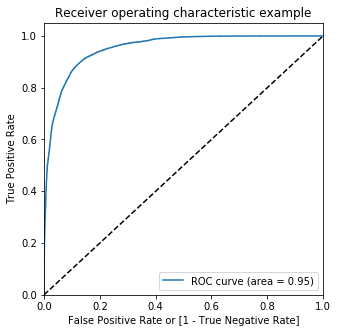

In [149]:
draw_roc(y_train_pred_Rforest.Churn, y_train_pred_Rforest.Churn_Probability)

#### Optimal cutoff probabilityso that  we get balanced sensitivity and specificity

In [150]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_Rforest.Churn_Probability.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      1    0.743490          1    1    1    1    1    1    1    1    1    1   
1      0    0.030789          0    1    0    0    0    0    0    0    0    0   
2      0    0.070508          0    1    1    1    0    0    0    0    0    0   
3      0    0.234192          0    1    1    0    0    0    0    0    0    0   
4      0    0.004095          0    1    0    0    0    0    0    0    0    0   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0

In [151]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.721242  0.997906  0.444578
0.2   0.2  0.819860  0.976700  0.663019
0.3   0.3  0.858972  0.954134  0.763810
0.4   0.4  0.881538  0.919210  0.843866
0.5   0.5  0.883345  0.868580  0.898110
0.6   0.6  0.867846  0.807686  0.928007
0.7   0.7  0.842400  0.734332  0.950469
0.8   0.8  0.815383  0.661029  0.969737
0.9   0.9  0.751191  0.516414  0.985968


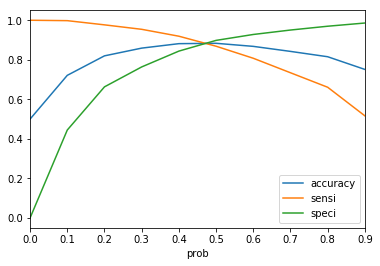

In [152]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### From the above chart we see that the sensitivity and specificity come in harmony at the probability of 0.5 and above. This would see a slight reduction in the accuracy as we may be looking at customers who might not ultimately churn but considering the problem it seems to be more important to make sure that we focus on who might churn and in the process if the call centre has to call people who might churn but dont really churn then that is a risk worth taking.

### Also, to note tht if the organization has lesser resources and does not want their team to be calling folks up, then they can decide to go for a slight lower probability 


In [153]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

y_train_pred_final.head()

Churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      1    0.743490          1    1    1    1    1    1    1    1    1    1   
1      0    0.030789          0    1    0    0    0    0    0    0    0    0   
2      0    0.070508          0    1    1    1    0    0    0    0    0    0   
3      0    0.234192          0    1    1    0    0    0    0    0    0    0   
4      0    0.004095          0    1    0    0    0    0    0    0    0    0   

   0.9  final_predicted  
0    0                1  
1    0                0  
2    0                0  
3    0                0  
4    0                0

In [154]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.789936645897691

In [155]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[13961,  5138],
       [ 2886, 16213]], dtype=int64)

In [156]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [157]:
print("TP = ",TP)
print("TN = ",TN)
print("FP = ",FP)
print("FN = ",FN)

TP =  16213
TN =  13961
FP =  5138
FN =  2886


In [158]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8488926121786481

In [159]:
# Let us calculate specificity
TN / float(TN+FP)

0.7309806796167339

In [160]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.26901932038326615


In [161]:
# Positive predictive value 
print (TP / float(TP+FP))

0.7593555336986558


In [162]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8286935359411172


#### Above are the %age figures which we get for the train. We will check the specificity and sensitivity on the TEST Data.

In [163]:
y_test_pred_Rforest.head()

Churn  Churn_Probability  Churn_Predicted
0      0           0.072134                0
1      1           0.187715                0
2      0           0.106940                0
3      0           0.288339                0
4      0           0.405936                0

In [164]:
y_test_pred_Rforest['final_predicted'] = y_test_pred_Rforest.Churn_Probability.map(lambda x: 1 if x > 0.50 else 0)

In [165]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred_Rforest.Churn, y_test_pred_Rforest.final_predicted)

0.8928210313447927

In [166]:
confusion2 = metrics.confusion_matrix(y_test_pred_Rforest.Churn, y_test_pred_Rforest.final_predicted )
confusion2

array([[4901,  534],
       [ 102,  397]], dtype=int64)

In [167]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [168]:
print("TP = ",TP)
print("TN = ",TN)
print("FP = ",FP)
print("FN = ",FN)

TP =  397
TN =  4901
FP =  534
FN =  102


In [169]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7955911823647295

In [170]:
# Let us calculate specificity
TN / float(TN+FP)

0.9017479300827966

In [171]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.09825206991720331


In [172]:
# positive predictive value 
print (TP / float(TP+FP))

0.4264232008592911


In [173]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9796122326604038


### 3rd Model - ADABOOST 

#### Going to use Adaboost on the Data to see the output. This will use tree as the base_estimator . Since we already did the tuning of the HyperParameters we will use the same Parameters for the Adaboost 
param_grid = {
    'max_depth': [9,12],
    'n_estimators': [100,200, 300], 
    'max_features': [5, 8]
}


In [174]:
from sklearn.ensemble import AdaBoostClassifier

# adaboost classifier with max 400 decision trees of depth=2
# learning_rate/shrinkage=
# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=400,
    learning_rate=1.5,
    algorithm="SAMME")


In [175]:
#DAtaFrame Split and SMOTE Applied for imbalance handling used here
# fit
adaboost_model_1.fit(X_train_SMT, y_train_SMT)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [176]:
# predictions
# the second column represents the probability of a click resulting in a download
predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.5104893 , 0.4895107 ],
       [0.52874654, 0.47125346],
       [0.52494714, 0.47505286],
       [0.50775741, 0.49224259],
       [0.50749471, 0.49250529],
       [0.49985819, 0.50014181],
       [0.50602401, 0.49397599],
       [0.52209455, 0.47790545],
       [0.50151038, 0.49848962],
       [0.52058822, 0.47941178]])

In [177]:
# metrics: AUC
metrics.roc_auc_score(y_test, predictions[:,1])

0.8978014907459814

### Tuning the HyperParameters for Adaboost

In [178]:
# parameter grid
# parameter grid
param_grid = {"base_estimator__max_depth" : [2, 5],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier(ccp_alpha=0.0,
                             class_weight=None,
                             criterion='gini',
                             max_depth=12,
                             max_features=8,
                             splitter='best')

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6 - to keep it a slightly slow learning rate than the default 1
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6, n_estimators=200,
    algorithm="SAMME")

In [179]:
# run grid search
folds = 3
grid_search_ABC = GridSearchCV(estimator=ABC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)


In [180]:
# fit 
grid_search_ABC.fit(X_train_SMT, y_train_SMT)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=12,
                                                                                max_features=8,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
        

In [181]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.079423      0.217763         0.149278        0.001250   
1       7.776887      0.102554         0.289890        0.008711   
2      11.606629      0.098456         0.421207        0.005779   
3       8.038483      0.173170         0.166923        0.003300   
4      16.139517      0.056843         0.320467        0.006215   
5      24.241199      0.154458         0.477708        0.015714   

  param_base_estimator__max_depth param_n_estimators  \
0                               2                200   
1                               2                400   
2                               2                600   
3                               5                200   
4                               5                400   
5                               5                600   

                                              params  split0_test_score  \
0  {'base_estimator__max_depth': 2, 'n_estimators...           0.940322   
1  {'base_estimator__max_depth': 2, 'n_estimators...           0.947937   
2  {'base_estimator__max_depth': 2, 'n_estimators...           0.948402   
3  {'base_estimator__max_depth': 5, 'n_estimators...           0.963190   
4  {'base_estimator__max_depth': 5, 'n_estimators...           0.967471   
5  {'base_estimator__max_depth': 5, 'n_estimators...           0.969413   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.956023           0.958458         0.951601        0.008037   
1           0.960114           0.961332         0.956461        0.006048   
2           0.962052           0.963710         0.958055        0.006859   
3           0.976108           0.975763         0.971687        0.006010   
4           0.977225           0.978703         0.974467        0.004983   
5           0.980234           0.981429         0.977025        0.005405   

   rank_test_score  split0_train_score  split1_train_score  \
0                6            0.958785            0.951116   
1                5            0.966926            0.955795   
2                4            0.968770            0.958090   
3                3            0.986807            0.978979   
4                2            0.989629            0.981037   
5                1            0.992752            0.985745   

   split2_train_score  mean_train_score  std_train_score  
0            0.954415          0.954772         0.003141  
1            0.957305          0.960009         0.004930  
2            0.959766          0.962208         0.004690  
3            0.977651          0.981146         0.004040  
4            0.982031          0.984232         0.003837  
5            0.985634          0.988044         0.003330

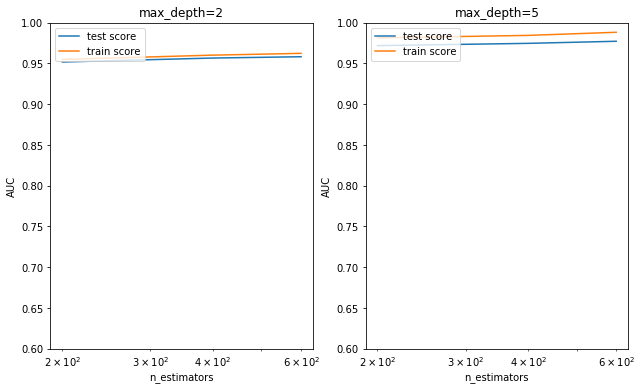

In [182]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    

    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]

    plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title("max_depth={0}".format(depth))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

    


In [211]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search_ABC.best_score_,'using',grid_search_ABC.best_params_)

We can get accuracy of 0.9770252842876216 using {'base_estimator__max_depth': 5, 'n_estimators': 600}


In [212]:
# model performance on test data with chosen hyperparameters

# base estimator
tree = DecisionTreeClassifier(max_depth=5)

# adaboost with the tree as base estimator
# learning rate is arbitrarily set, we'll discuss learning_rate below
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=600,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [213]:
# predict on test data
predictions_Prob = ABC.predict_proba(X_test)
predictions = ABC.predict(X_test)
predictions_Prob[:10]

array([[0.55353215, 0.44646785],
       [0.5862872 , 0.4137128 ],
       [0.5522839 , 0.4477161 ],
       [0.5425209 , 0.4574791 ],
       [0.62535659, 0.37464341],
       [0.53122833, 0.46877167],
       [0.50983383, 0.49016617],
       [0.56324883, 0.43675117],
       [0.56036768, 0.43963232],
       [0.6094851 , 0.3905149 ]])

In [214]:
# roc auc
metrics.roc_auc_score(y_test, predictions_Prob[:, 1])

0.9027102963977633

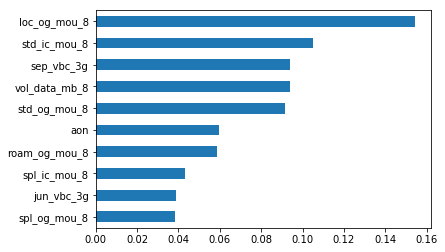

In [215]:
#FEatures based on weightage
importances = ABC.feature_importances_
weights = pd.Series(importances,
                 index=X_train_SMT.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')


#### The important Features identified by Adaboost are as follows:
1. loc_og_mou_8
2. std_ic_mou_8
3. sep_vbc_3g
4. vol_data_mb_8
5. std_og_mou_8


In [216]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [217]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5435
           1       0.68      0.53      0.59       499

    accuracy                           0.94      5934
   macro avg       0.82      0.75      0.78      5934
weighted avg       0.93      0.94      0.94      5934



In [218]:
print(confusion_matrix(y_test,predictions))

[[5310  125]
 [ 236  263]]


In [219]:
#Creating table for test churn
y_test_pred_Adaboost = pd.DataFrame({'Churn':y_test.values, 'Churn_Probability':pd.Series(prediction_prob_test[:,1]),'Churn_Predicted':pd.Series(predictions)  })


In [220]:
y_test_pred_Adaboost.head()

Churn  Churn_Probability  Churn_Predicted
0      0           0.072134                0
1      1           0.187715                0
2      0           0.106940                0
3      0           0.288339                0
4      0           0.405936                0

In [221]:
y_test_pred_Adaboost['final_predicted'] = y_test_pred_Adaboost.Churn_Probability.map(lambda x: 1 if x > 0.50 else 0)

In [222]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred_Rforest.Churn, y_test_pred_Rforest.final_predicted)

0.8928210313447927

In [223]:
confusion2 = metrics.confusion_matrix(y_test_pred_Rforest.Churn, y_test_pred_Rforest.final_predicted )
confusion2

array([[4901,  534],
       [ 102,  397]], dtype=int64)

In [224]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [225]:
print("TP = ",TP)
print("TN = ",TN)
print("FP = ",FP)
print("FN = ",FN)

TP =  397
TN =  4901
FP =  534
FN =  102


In [226]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7955911823647295

In [227]:
# Let us calculate specificity
TN / float(TN+FP)

0.9017479300827966

In [228]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.09825206991720331


In [229]:
# positive predictive value 
print (TP / float(TP+FP))

0.4264232008592911


In [230]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9796122326604038


## As we can see above we have created three Models
### PCA + Logistic Regression
### RandomForest
### AdaBoost

### WE observe that RandomForest and AdaBoost are better ways to creaet the model. They not only give us the influencing variables but they also help build an effective model with ease. PCA Would have been good if we had a large number of variables.

#### We had started with too many variables, but by combining some of the variables we were able to reduce the variables. And we were further able to reduce considering the Multi-Colinearity and observing that some of the variables like the last day of the month etc are not relevant to any model. We also dropped variables which had a single value for all the rows.

### Regarding RandomForest :

1. We fine tuned the HyperParameters so as to be able to get theoptimal values for the maximum depth of the tree's, the number of Trees to create and also the number of features we shold pick for the model. Using these HyperParameters we further built and model. This model was then subjected to further analysis to see the Accuracy of the data, Sensitivity and Specificity of the Data.

2. We observed that though the Accuracy was very high, but we were getting a low number for the Sensitivity which is crucial for us as that is defining how successful are we at identifying the 1's which is the people who will Churn. We further fin-tuned this and found that it is a better idea to use the Probability Threshold of 0.5 . this brings down the accuracy a little but takes up the Sensitivity as well as the Specificity. For the problem statement, though there is more focus on the 1's , none the less it is also important to focus on successfully identifying the 0's as well.

3. From the Model, we have been able to identify the below variables which are high influencing variables

        a. loc_og_mou_8
        b. vol_data_mb_8
        c. roam_og_mou_8
        d. std_ic_mou_8
        e. roam_ic_mou_8

### From AdaBoost : 
1. we create an AdaBoost model using some of the HyperParameters which we optimized as we went about with the model. We created a DecisiontTree instance which was then used to create an Adaboost model.
2. From the list of possible parameters which we gathered, from the chart as well as the best_values we observed and picked the suggested values and built the rest of the model. 
3. We were surely able to get numbers better than the RandomForest - and also got slightly different variables of the sort. But to sum it up,most of the high impacting variables were almost the same. The variables given by Adaboost are as below:
        a. loc_og_mou_8
        b. std_ic_mou_8
        c. sep_vbc_3g
        d. vol_data_mb_8
        e. std_og_mou_8
        
    We can observe that many of these are common between the two models. Some of the most important variables are:
        a. log_og_mou_8
        b. std_ic_mou_8
        c. vol_data_mb_8
        d. roam_og_mou_8


    From the above, we can make an estimation that probably the user/customer is moving to a different city and planning to take a different number which could be the reason of a sudden change or could be (s)he is traveling during the month and using a different number for the purpose. In either case, the customer care can get in touch with the person and share some of the below options :
    1. Plans with better roaming and STD facility if the movement is for a short duration and frequent
    2. New plans if the movement is permanent and instead of moving to a different network, the user can remain on the same network and number, but different zone withot penalty
    3. Data / Calling plan options to reduce expenses when roaming or frequently calling some std numbers.
   
    Creating a visualization analysis of the above identified variables can help us understand what direction is the data leaning towards so as to be able to approach/retain/sell better to the user/customer. 


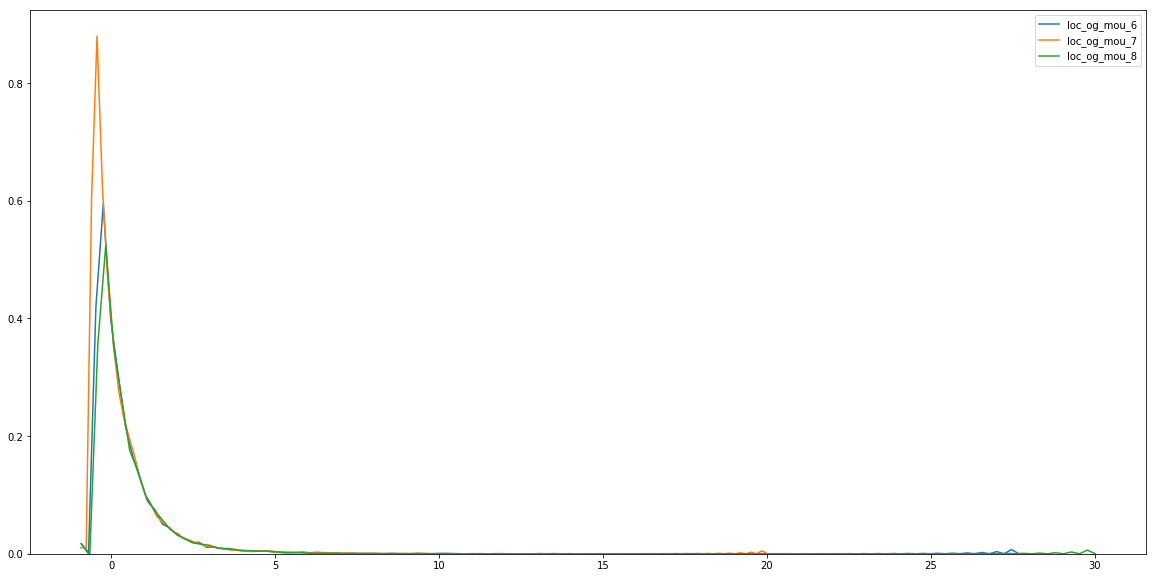

In [203]:
plt.figure(figsize=(20, 10))

sns.distplot(Telecom_churn_Priority_df[['loc_og_mou_6']], hist=False, label='loc_og_mou_6')
sns.distplot(Telecom_churn_Priority_df[['loc_og_mou_7']], hist=False, label='loc_og_mou_7')
sns.distplot(Telecom_churn_Priority_df[['loc_og_mou_8']], hist=False, label='loc_og_mou_8')
plt.show()

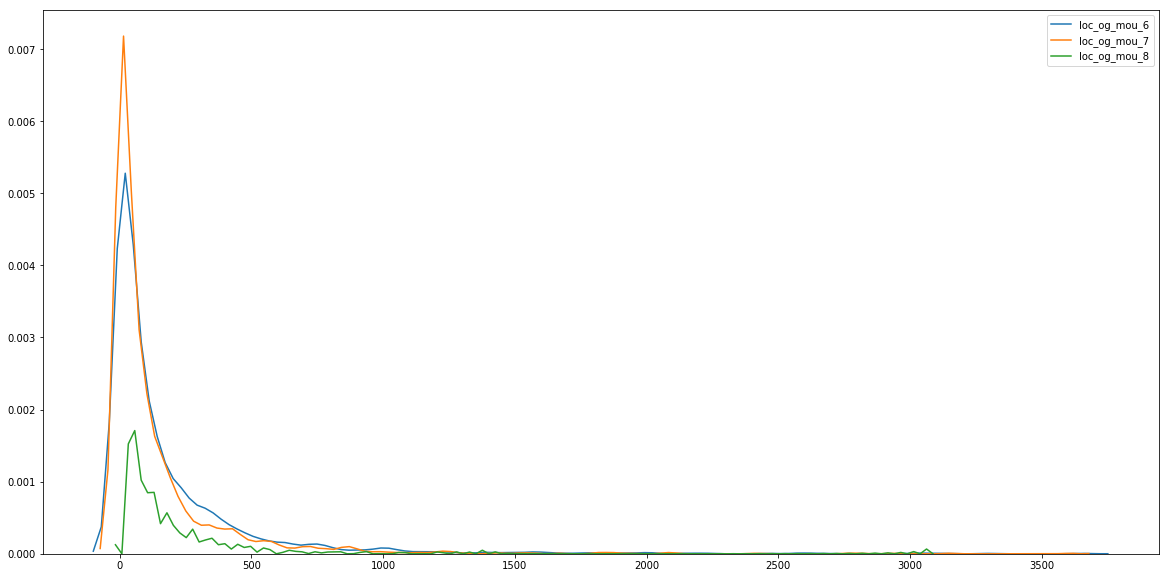

In [204]:
plt.figure(figsize=(20, 10))

sns.distplot(Churned_df[['loc_og_mou_6']], hist=False, label='loc_og_mou_6')
sns.distplot(Churned_df[['loc_og_mou_7']], hist=False, label='loc_og_mou_7')
sns.distplot(Churned_df[['loc_og_mou_8']], hist=False, label='loc_og_mou_8')
plt.show()

#### We see a reducing trend in the local outgoing calls and during the Action month we see a sudden drop. We can see that during the month of July the customer was starting to slowly move away from the network which all of a sudden made a lot of change in the month of August.

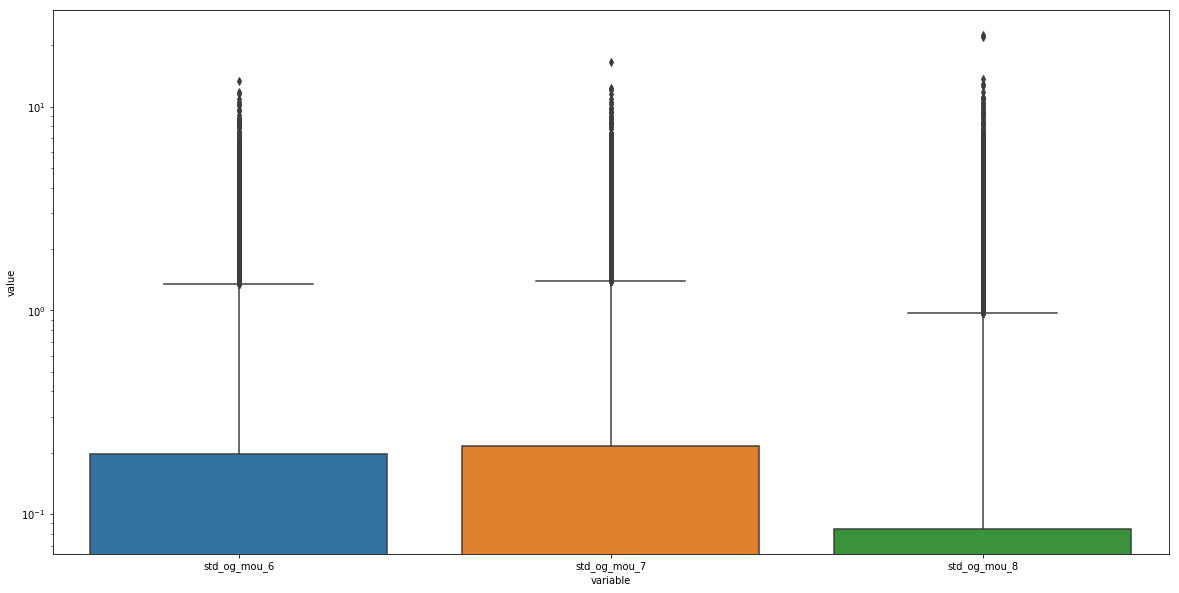

In [205]:
plt.figure(figsize=(20, 10))

sns.boxplot(x="variable", y="value", data = pd.melt(Telecom_churn_Priority_df[['std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8']]))
plt.yscale('log')
plt.show()

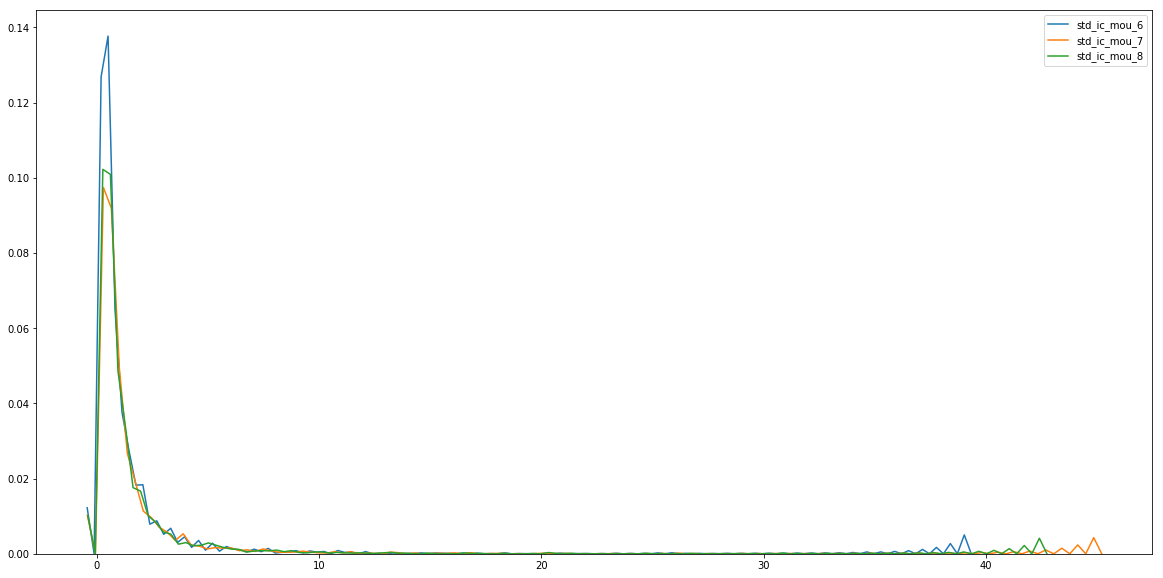

In [206]:
plt.figure(figsize=(20, 10))

sns.distplot(Telecom_churn_Priority_df[['std_ic_mou_6']], hist=False, label='std_ic_mou_6')
sns.distplot(Telecom_churn_Priority_df[['std_ic_mou_7']], hist=False, label='std_ic_mou_7')
sns.distplot(Telecom_churn_Priority_df[['std_ic_mou_8']], hist=False, label='std_ic_mou_8')
plt.show()

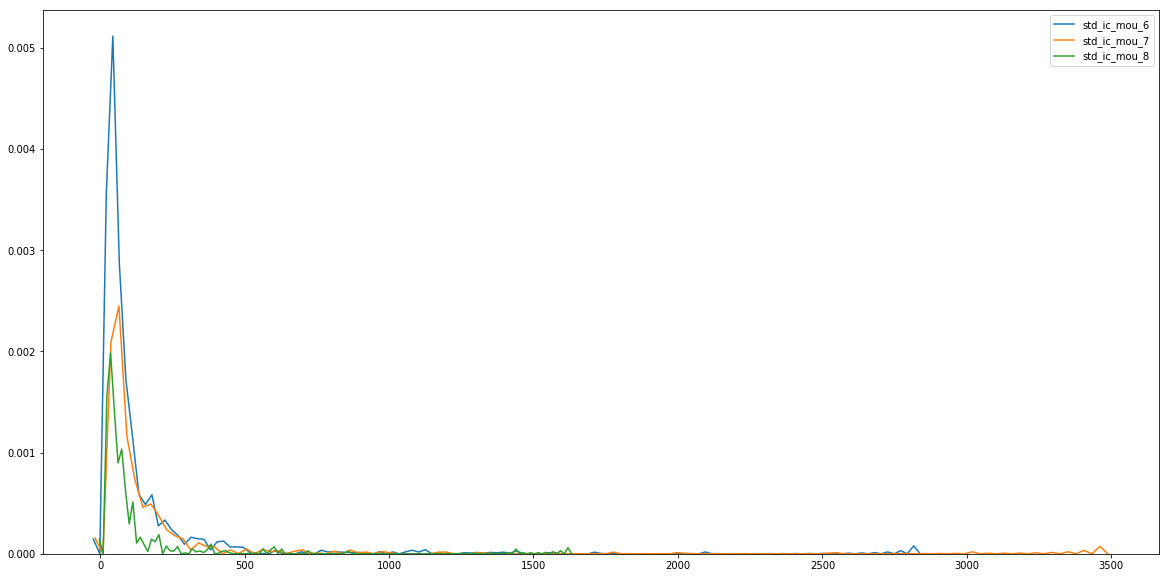

In [207]:
#Incoming STD Calls to the churning user
plt.figure(figsize=(20, 10))

sns.distplot(Churned_df[['std_ic_mou_6']], hist=False, label='std_ic_mou_6')
sns.distplot(Churned_df[['std_ic_mou_7']], hist=False, label='std_ic_mou_7')
sns.distplot(Churned_df[['std_ic_mou_8']], hist=False, label='std_ic_mou_8')
plt.show()

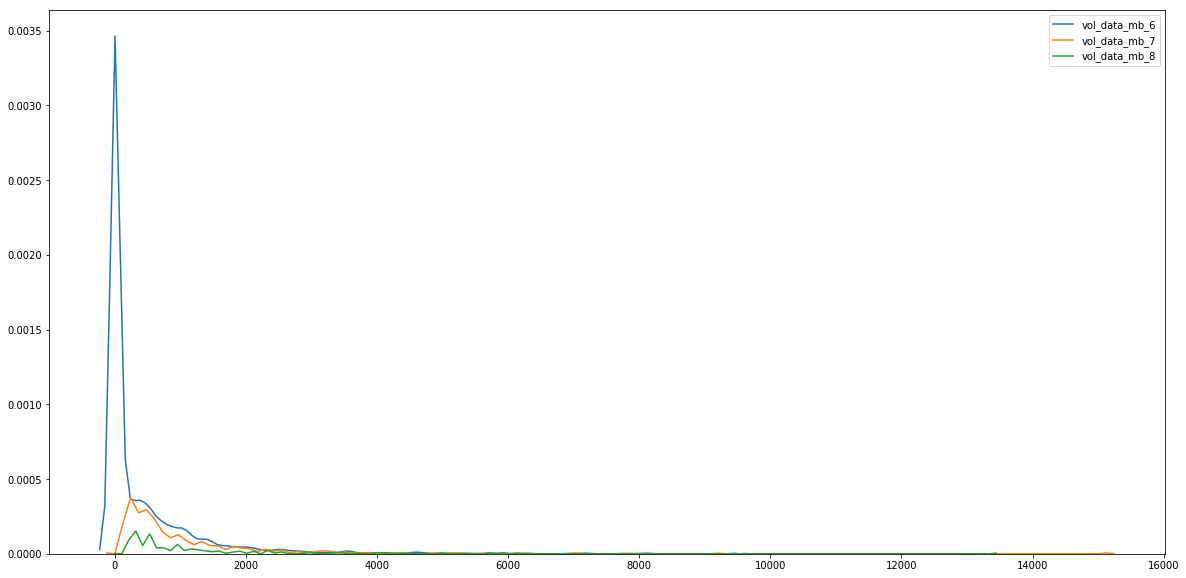

In [208]:
plt.figure(figsize=(20, 10))

sns.distplot(Churned_df[['vol_data_mb_6']], hist=False, label='vol_data_mb_6')
sns.distplot(Churned_df[['vol_data_mb_7']], hist=False, label='vol_data_mb_7')
sns.distplot(Churned_df[['vol_data_mb_8']], hist=False, label='vol_data_mb_8')
plt.show()

#### Data Usage has dropped from 25 to less than 5, some are not even using the network probably

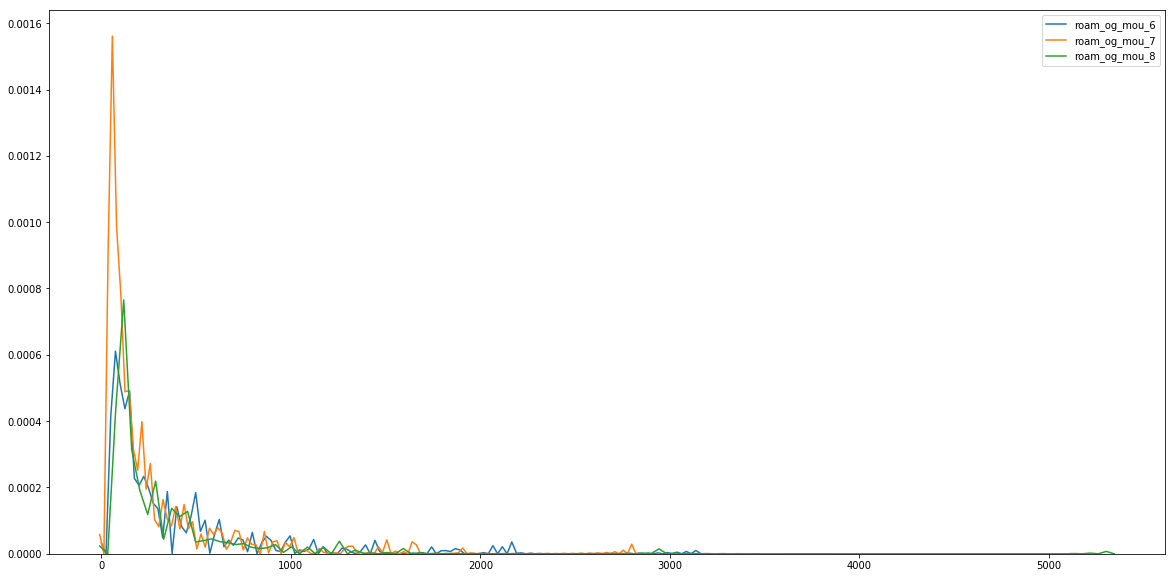

In [209]:
plt.figure(figsize=(20, 10))

sns.distplot(Churned_df[['roam_og_mou_6']], hist=False, label='roam_og_mou_6')
sns.distplot(Churned_df[['roam_og_mou_7']], hist=False, label='roam_og_mou_7')
sns.distplot(Churned_df[['roam_og_mou_8']], hist=False, label='roam_og_mou_8')
plt.show()

#### This is a total reverse, shows an increase in roaming calls - goes to say customer is travelling

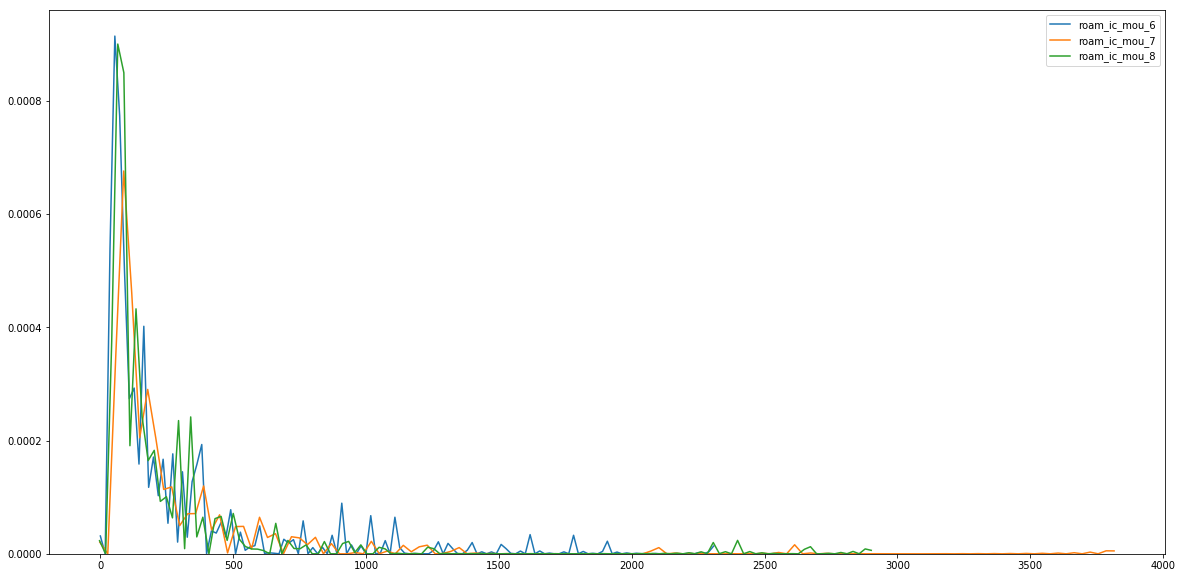

In [210]:
plt.figure(figsize=(20, 10))

sns.distplot(Churned_df[['roam_ic_mou_6']], hist=False, label='roam_ic_mou_6')
sns.distplot(Churned_df[['roam_ic_mou_7']], hist=False, label='roam_ic_mou_7')
sns.distplot(Churned_df[['roam_ic_mou_8']], hist=False, label='roam_ic_mou_8')
plt.show()

### The above analysis confirms our estimation that the user has been either travelling to a different city / network/zone or is planning to move out of the city/zone. And the major reason that the churn seems to be happening is due to the reason of plan becoming expensive on roaming or for making std calls to network outside the home network.

### The user probably needs to take a different plan and request a change in home network instead of getting a new number or moving to a different networl. It has been observed that when people move to different cities, they are more exprerimentive with the network and since will be getting a new number, do not mind changing the network too. In such a scenario, if Telecom companies can identify such customers and come up with plans conducive to the user so that (s)he does not need to change number and use the phone under same or better rates, then the likelyhood of the customer moving to a different provider will reduce.